In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot
    
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# Convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for specific humidity
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for specific humidity
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for specific humidity
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    #print("Agg:")
    agg.columns = names
    #print(type(agg))
    #print(agg)

    #print("Test columns:")
    #print(agg.iloc[:, -37]) # Column containing response actual values (specific humidity) at time t-3
    #print(agg.iloc[:, -25]) # Column containing response actual values (specific humidity) at time t-2
    #print(agg.iloc[:, -13]) # Column containing response actual values (specific humidity) at time t-1
    #print(agg.iloc[:, -1]) # Column containing response actual values (specific humidity) at time t
    
    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 27 time steps (the first 23 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 26-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 23 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    #diff_values_training = np.array(diff_values_for_training)
    #diff_values_training = diff_values_training.reshape(1, -1) 
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (specific_humidity) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    #print("Scaled values rows:")
    #print(len(scaled_values))

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    # Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    
    
    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 2:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 1
if n_seq > 3:
    n_lag = 25 - n_seq
else:
    n_lag = 22
n_time_steps = 27
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([5, 9, 21, 22, 41, 42, 45, 46, 52, 66, 68, 72, 79, 81, 82, 83, 90, 92, 95])
test_array.append([4, 10, 47, 53, 94])
    
train_array.append([4, 9, 10, 21, 41, 45, 46, 47, 52, 53, 66, 68, 81, 82, 83, 90, 92, 94, 95])
test_array.append([5, 22, 42, 72, 79])
    
train_array.append([4, 5, 10, 21, 22, 41, 42, 46, 47, 52, 53, 72, 79, 82, 83, 90, 92, 94, 95])
test_array.append([9, 45, 66, 68, 81])
    
train_array.append([4, 5, 9, 10, 21, 22, 42, 45, 47, 52, 53, 66, 68, 72, 79, 81, 82, 92, 94, 95])
test_array.append([41, 46, 83, 90])
    
train_array.append([4, 5, 9, 10, 22, 41, 42, 45, 46, 47, 53, 66, 68, 72, 79, 81, 83, 90, 94])
test_array.append([21, 52, 82, 92, 95])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Yearly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')

# Swap columns 'temperatures' and 'specific_humidity' directly
df['A'] = df['temperatures']
df['temperatures'] = df['specific_humidity']
df['specific_humidity'] = df['A']
df = df.drop(columns=['A'])
# Rename columns
df = df.rename(columns={'temperatures': 'specific_humidity', 'specific_humidity': 'temperatures'})

print(df)
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'date', 'latitude', 'longitude', 'elevation'], axis=1)
    
X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['specific_humidity'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['specific_humidity'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)

print(df_trimmed)
print(new_df)
print(X[0])

#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of the train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of the validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
    #print("Train_X Fold "+str(i)+":")
    #print(len(train_X[i]))
    #print(len(train_X[i][0]))
    #print(len(train_X[i][0][0])) 
    #print("Train_y Fold "+str(i)+":")
    #print(len(train_y[i]))
    #print(len(train_y[i][0]))
    #print(train_y[i][0][0])
    #print("Validation_X Fold "+str(i)+":")
    #print(len(val_X[i]))
    #print(len(val_X[i][0]))
    #print(len(val_X[i][0][0]))
    #print("Validation_y Fold "+str(i)+":")
    #print(len(val_y[i]))
    #print(len(val_y[i][0]))
    #print(val_y[i][0][0])
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    if i==3:
        train_size = 20
        val_size = 4
    else:
        train_size = 19
        val_size = 5
        
    for k in range(train_size):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)
     

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(train_size):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['specific_humidity']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(val_size):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(val_size):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['specific_humidity']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(train_size):
        train2.append(train1[k][0])
        
    for k in range(2):
        test2.append(test1[k][0])

    for k in range(val_size-2):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + 12*n_lag
    train1 = np.array(train[i]).reshape(train_size, dim_size)
    test1 = np.array(test[i]).reshape(2, dim_size)
    validation1 = np.array(validation[i]).reshape(val_size-2, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]


Model Parameters:
n_lag (number of input time steps): 22
n_seq (number of output/future prediction time steps): 1
C:\Users\User
C:\Users\User\Modeling\
     file_id        date  specific_humidity          slp  vapor_pressure  \
0       6678  1998-12-31          12.816968  1016.202508       20.726068   
1       6678  1999-12-31          12.330412  1017.480181       19.960131   
2       6678  2000-12-31          12.136613  1018.259826       19.655271   
3       6678  2001-12-31          11.897962  1018.414173       19.285320   
4       6678  2002-12-31          12.751085  1017.916636       20.638060   
..       ...         ...                ...          ...             ...   
643     8000  2020-12-31           5.146134  1016.944161        8.168785   
644     8000  2021-12-31           5.239193  1016.159983        8.312383   
645     8000  2022-12-31           5.362553  1017.898453        8.512894   
646     8000  2023-12-31           5.430746  1016.166709        8.612808   
647     8000

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

1
22
(19, 265)
(2, 265)


[I 2025-06-06 14:57:42,110] A new study created in memory with name: no-name-f1b75c1e-811e-4197-9e89-6c5ea8637863
[I 2025-06-06 14:59:11,501] Trial 0 finished with value: 0.1110048808157444 and parameters: {'lr': 0.0023568676771720796, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4460397043845413}. Best is trial 0 with value: 0.1110048808157444.


Cross Validation Accuracies:
[0.050324659794569016, 0.12181844562292099, 0.08141961693763733, 0.14533473551273346, 0.1561269462108612]
Mean Cross Validation Accuracy:
0.1110048808157444
Standard Deviation of Cross Validation Accuracy:
0.03972115294095203


[I 2025-06-06 15:01:49,596] Trial 1 finished with value: 0.5116847634315491 and parameters: {'lr': 0.020868790691907158, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.35297411383990085}. Best is trial 0 with value: 0.1110048808157444.


Cross Validation Accuracies:
[0.4089759588241577, 0.6784152984619141, 0.5035091042518616, 0.41493725776672363, 0.5525861978530884]
Mean Cross Validation Accuracy:
0.5116847634315491
Standard Deviation of Cross Validation Accuracy:
0.0994464865628931


[I 2025-06-06 15:03:09,798] Trial 2 finished with value: 0.9870865762233734 and parameters: {'lr': 0.20859121939228273, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.4428140151874308}. Best is trial 0 with value: 0.1110048808157444.


Cross Validation Accuracies:
[0.13917812705039978, 0.9093210101127625, 1.5474382638931274, 1.3780028820037842, 0.9614925980567932]
Mean Cross Validation Accuracy:
0.9870865762233734
Standard Deviation of Cross Validation Accuracy:
0.48835660027671535


[I 2025-06-06 15:05:29,599] Trial 3 finished with value: 0.10288771465420724 and parameters: {'lr': 0.008427555228811048, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.1700394146434987}. Best is trial 3 with value: 0.10288771465420724.


Cross Validation Accuracies:
[0.08988099545240402, 0.1212235763669014, 0.06081348657608032, 0.20505094528198242, 0.037469569593667984]
Mean Cross Validation Accuracy:
0.10288771465420724
Standard Deviation of Cross Validation Accuracy:
0.05829661848336931


[I 2025-06-06 15:07:04,721] Trial 4 finished with value: 0.10000962615013123 and parameters: {'lr': 0.0024886407720952643, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.1992410637256582}. Best is trial 4 with value: 0.10000962615013123.


Cross Validation Accuracies:
[0.10962119698524475, 0.13817305862903595, 0.07780718803405762, 0.13328386843204498, 0.04116281867027283]
Mean Cross Validation Accuracy:
0.10000962615013123
Standard Deviation of Cross Validation Accuracy:
0.03636454339269343


[I 2025-06-06 15:10:02,085] Trial 5 finished with value: 24.99404525756836 and parameters: {'lr': 0.23810779856930972, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.19192222306078344}. Best is trial 4 with value: 0.10000962615013123.


Cross Validation Accuracies:
[18.455854415893555, 26.61235809326172, 28.551740646362305, 22.852628707885742, 28.497644424438477]
Mean Cross Validation Accuracy:
24.99404525756836
Standard Deviation of Cross Validation Accuracy:
3.87001148207918


[I 2025-06-06 15:11:30,040] Trial 6 finished with value: 0.27941460609436036 and parameters: {'lr': 0.06947961618948054, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.4802921528629621}. Best is trial 4 with value: 0.10000962615013123.


Cross Validation Accuracies:
[0.2694410979747772, 0.33319392800331116, 0.32824066281318665, 0.23686785995960236, 0.22932948172092438]
Mean Cross Validation Accuracy:
0.27941460609436036
Standard Deviation of Cross Validation Accuracy:
0.04403275016181951


[I 2025-06-06 15:13:05,571] Trial 7 finished with value: 0.3380486905574799 and parameters: {'lr': 0.004069427645843675, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.36534271685812836}. Best is trial 4 with value: 0.10000962615013123.


Cross Validation Accuracies:
[0.36113443970680237, 0.32268238067626953, 0.31912678480148315, 0.38478362560272217, 0.30251622200012207]
Mean Cross Validation Accuracy:
0.3380486905574799
Standard Deviation of Cross Validation Accuracy:
0.03024507988434577


[I 2025-06-06 15:14:36,285] Trial 8 finished with value: 0.14421743974089624 and parameters: {'lr': 0.0012696067293689682, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2570367725736836}. Best is trial 4 with value: 0.10000962615013123.


Cross Validation Accuracies:
[0.028392639011144638, 0.19837114214897156, 0.16106928884983063, 0.12169075012207031, 0.211563378572464]
Mean Cross Validation Accuracy:
0.14421743974089624
Standard Deviation of Cross Validation Accuracy:
0.06584059536375339


[I 2025-06-06 15:16:18,402] Trial 9 finished with value: 0.11443747584708035 and parameters: {'lr': 0.0022520569476136114, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3350185339284506}. Best is trial 4 with value: 0.10000962615013123.


Cross Validation Accuracies:
[0.2568826675415039, 0.12323988229036331, 0.1092182919383049, 0.07950469106435776, 0.003341846400871873]
Mean Cross Validation Accuracy:
0.11443747584708035
Standard Deviation of Cross Validation Accuracy:
0.08241103471192765


[I 2025-06-06 15:17:49,346] Trial 10 finished with value: 0.10395424142479896 and parameters: {'lr': 0.01940838829968841, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.10049097048807108}. Best is trial 4 with value: 0.10000962615013123.


Cross Validation Accuracies:
[0.11403016746044159, 0.1260746717453003, 0.07141058146953583, 0.15718711912631989, 0.05106866732239723]
Mean Cross Validation Accuracy:
0.10395424142479896
Standard Deviation of Cross Validation Accuracy:
0.03815901136782608


[I 2025-06-06 15:19:53,173] Trial 11 finished with value: 0.0710003450512886 and parameters: {'lr': 0.008058049037660662, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.16701868973728515}. Best is trial 11 with value: 0.0710003450512886.


Cross Validation Accuracies:
[0.06011731177568436, 0.13079380989074707, 0.05271276831626892, 0.07156254351139069, 0.03981529176235199]
Mean Cross Validation Accuracy:
0.0710003450512886
Standard Deviation of Cross Validation Accuracy:
0.03162580569524532


[I 2025-06-06 15:21:38,586] Trial 12 finished with value: 0.09898083768785 and parameters: {'lr': 0.007483688663440721, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.2418533617460274}. Best is trial 11 with value: 0.0710003450512886.


Cross Validation Accuracies:
[0.12498481571674347, 0.12864716351032257, 0.08015571534633636, 0.13808904588222504, 0.02302744798362255]
Mean Cross Validation Accuracy:
0.09898083768785
Standard Deviation of Cross Validation Accuracy:
0.04291631938561847


[I 2025-06-06 15:23:35,280] Trial 13 finished with value: 0.0864201464690268 and parameters: {'lr': 0.008630154366868856, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.2558139339913665}. Best is trial 11 with value: 0.0710003450512886.


Cross Validation Accuracies:
[0.027862170711159706, 0.13130976259708405, 0.0644788146018982, 0.2060357630252838, 0.0024142214097082615]
Mean Cross Validation Accuracy:
0.0864201464690268
Standard Deviation of Cross Validation Accuracy:
0.07387885675116002


[I 2025-06-06 15:25:32,589] Trial 14 finished with value: 0.09752323925495147 and parameters: {'lr': 0.059743264470381204, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.1071175300334149}. Best is trial 11 with value: 0.0710003450512886.


Cross Validation Accuracies:
[0.10478466004133224, 0.12964902818202972, 0.07518720626831055, 0.12787793576717377, 0.0501173660159111]
Mean Cross Validation Accuracy:
0.09752323925495147
Standard Deviation of Cross Validation Accuracy:
0.030829911882811024


[I 2025-06-06 15:27:50,584] Trial 15 finished with value: 0.08580554574728012 and parameters: {'lr': 0.8138005453967533, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.2845168322682374}. Best is trial 11 with value: 0.0710003450512886.


Cross Validation Accuracies:
[0.08778778463602066, 0.13904908299446106, 0.07132405042648315, 0.11945204436779022, 0.011414766311645508]
Mean Cross Validation Accuracy:
0.08580554574728012
Standard Deviation of Cross Validation Accuracy:
0.04407854845793239


[I 2025-06-06 15:29:41,373] Trial 16 finished with value: 0.1747586578130722 and parameters: {'lr': 0.3947843332134506, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.31345228308558726}. Best is trial 11 with value: 0.0710003450512886.


Cross Validation Accuracies:
[0.10561864078044891, 0.12479748576879501, 0.08369322121143341, 0.11091967672109604, 0.44876426458358765]
Mean Cross Validation Accuracy:
0.1747586578130722
Standard Deviation of Cross Validation Accuracy:
0.1376400105051554


[I 2025-06-06 15:31:54,120] Trial 17 finished with value: 0.09623787477612496 and parameters: {'lr': 0.7988558035187864, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.14443190182384713}. Best is trial 11 with value: 0.0710003450512886.


Cross Validation Accuracies:
[0.10137510299682617, 0.1294257789850235, 0.07481435686349869, 0.1290033608675003, 0.04657077416777611]
Mean Cross Validation Accuracy:
0.09623787477612496
Standard Deviation of Cross Validation Accuracy:
0.03202247080088347


[I 2025-06-06 15:33:45,595] Trial 18 finished with value: 0.6911848664283753 and parameters: {'lr': 0.07480504283228614, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.2850258301445508}. Best is trial 11 with value: 0.0710003450512886.


Cross Validation Accuracies:
[1.3841074705123901, 0.46212324500083923, 0.5045984387397766, 0.4075864255428314, 0.6975087523460388]
Mean Cross Validation Accuracy:
0.6911848664283753
Standard Deviation of Cross Validation Accuracy:
0.35997042208075597


[I 2025-06-06 15:36:15,166] Trial 19 finished with value: 0.09348927438259125 and parameters: {'lr': 0.027492757605352792, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.3897868222703099}. Best is trial 11 with value: 0.0710003450512886.


Cross Validation Accuracies:
[0.08178405463695526, 0.12109976261854172, 0.07077819854021072, 0.1282995194196701, 0.06548483669757843]
Mean Cross Validation Accuracy:
0.09348927438259125
Standard Deviation of Cross Validation Accuracy:
0.02611951716795234


[I 2025-06-06 15:38:41,401] Trial 20 finished with value: 0.40159515142440794 and parameters: {'lr': 0.9385502203448685, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.22273084236709445}. Best is trial 11 with value: 0.0710003450512886.


Cross Validation Accuracies:
[0.16633325815200806, 0.1328704059123993, 0.9279609322547913, 0.7273073196411133, 0.053503841161727905]
Mean Cross Validation Accuracy:
0.40159515142440794
Standard Deviation of Cross Validation Accuracy:
0.35549347653947283


[I 2025-06-06 15:41:06,061] Trial 21 finished with value: 0.1182257816195488 and parameters: {'lr': 0.009385105352193477, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.27884051060475135}. Best is trial 11 with value: 0.0710003450512886.


Cross Validation Accuracies:
[0.15927669405937195, 0.13398806750774384, 0.15210138261318207, 0.06511420756578445, 0.08064855635166168]
Mean Cross Validation Accuracy:
0.1182257816195488
Standard Deviation of Cross Validation Accuracy:
0.03824675298256074


[I 2025-06-06 15:43:36,222] Trial 22 finished with value: 0.09226420372724534 and parameters: {'lr': 0.012751099117398678, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.22422109922514483}. Best is trial 11 with value: 0.0710003450512886.


Cross Validation Accuracies:
[0.07966170459985733, 0.12091557681560516, 0.10497444123029709, 0.09602025151252747, 0.059749044477939606]
Mean Cross Validation Accuracy:
0.09226420372724534
Standard Deviation of Cross Validation Accuracy:
0.021036243854173315


[I 2025-06-06 15:45:56,304] Trial 23 finished with value: 0.08354389667510986 and parameters: {'lr': 0.005257102578779613, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.16804942303094023}. Best is trial 11 with value: 0.0710003450512886.


Cross Validation Accuracies:
[0.10005643218755722, 0.14515595138072968, 0.05502679571509361, 0.1133747547864914, 0.004105549305677414]
Mean Cross Validation Accuracy:
0.08354389667510986
Standard Deviation of Cross Validation Accuracy:
0.04915743136029359


[I 2025-06-06 15:48:04,673] Trial 24 finished with value: 0.098910591006279 and parameters: {'lr': 0.00463433555627523, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.14650121077403624}. Best is trial 11 with value: 0.0710003450512886.


Cross Validation Accuracies:
[0.1302260309457779, 0.126726895570755, 0.11881369352340698, 0.06846701353788376, 0.05031932145357132]
Mean Cross Validation Accuracy:
0.098910591006279
Standard Deviation of Cross Validation Accuracy:
0.03298017572376907


[I 2025-06-06 15:49:27,711] Trial 25 finished with value: 0.09741361290216446 and parameters: {'lr': 0.03664768844852603, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.14370630852410618}. Best is trial 11 with value: 0.0710003450512886.


Cross Validation Accuracies:
[0.1474999636411667, 0.12644006311893463, 0.07053573429584503, 0.07992272824048996, 0.06266957521438599]
Mean Cross Validation Accuracy:
0.09741361290216446
Standard Deviation of Cross Validation Accuracy:
0.03342656698499205


[I 2025-06-06 15:52:01,728] Trial 26 finished with value: 0.1322997808456421 and parameters: {'lr': 0.0010538056778184946, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.1944049893670633}. Best is trial 11 with value: 0.0710003450512886.


Cross Validation Accuracies:
[0.11864225566387177, 0.13838347792625427, 0.10823025554418564, 0.17850463092327118, 0.1177382841706276]
Mean Cross Validation Accuracy:
0.1322997808456421
Standard Deviation of Cross Validation Accuracy:
0.025099030931928154


[I 2025-06-06 15:54:52,459] Trial 27 finished with value: 0.08642781302332878 and parameters: {'lr': 0.004484902714011831, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.16884070171395438}. Best is trial 11 with value: 0.0710003450512886.


Cross Validation Accuracies:
[0.11485373228788376, 0.13503402471542358, 0.07286696135997772, 0.07161431014537811, 0.03777003660798073]
Mean Cross Validation Accuracy:
0.08642781302332878
Standard Deviation of Cross Validation Accuracy:
0.03447176372664502


[I 2025-06-06 15:56:59,215] Trial 28 finished with value: 0.10563564896583558 and parameters: {'lr': 0.13792763423186316, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.31843655137856985}. Best is trial 11 with value: 0.0710003450512886.


Cross Validation Accuracies:
[0.08632588386535645, 0.12128561735153198, 0.05254252254962921, 0.15818621218204498, 0.10983800888061523]
Mean Cross Validation Accuracy:
0.10563564896583558
Standard Deviation of Cross Validation Accuracy:
0.0352587297971734


[I 2025-06-06 15:58:22,965] Trial 29 finished with value: 0.0958750531077385 and parameters: {'lr': 0.016275349171755805, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.4161769986119238}. Best is trial 11 with value: 0.0710003450512886.


Cross Validation Accuracies:
[0.1027316302061081, 0.12754958868026733, 0.07118353992700577, 0.12436122447252274, 0.053549282252788544]
Mean Cross Validation Accuracy:
0.0958750531077385
Standard Deviation of Cross Validation Accuracy:
0.02919894694637176


[I 2025-06-06 16:00:17,174] Trial 30 finished with value: 0.2667505629360676 and parameters: {'lr': 0.04083119839551902, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.22241674888985846}. Best is trial 11 with value: 0.0710003450512886.


Cross Validation Accuracies:
[0.10691992193460464, 0.9470749497413635, 0.07056046277284622, 0.15962372720241547, 0.04957375302910805]
Mean Cross Validation Accuracy:
0.2667505629360676
Standard Deviation of Cross Validation Accuracy:
0.3422044962248929


[I 2025-06-06 16:02:19,021] Trial 31 finished with value: 0.12216903194785118 and parameters: {'lr': 0.0027321216228874895, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.267372143181494}. Best is trial 11 with value: 0.0710003450512886.


Cross Validation Accuracies:
[0.04399341717362404, 0.1263464242219925, 0.19915303587913513, 0.12141423672437668, 0.11993804574012756]
Mean Cross Validation Accuracy:
0.12216903194785118
Standard Deviation of Cross Validation Accuracy:
0.049114073803993887


[I 2025-06-06 16:04:20,936] Trial 32 finished with value: 0.11026598811149597 and parameters: {'lr': 0.006825075353389215, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.2460362760917488}. Best is trial 11 with value: 0.0710003450512886.


Cross Validation Accuracies:
[0.11922075599431992, 0.1620560586452484, 0.12095602601766586, 0.06880678236484528, 0.08029031753540039]
Mean Cross Validation Accuracy:
0.11026598811149597
Standard Deviation of Cross Validation Accuracy:
0.033148401927668776


[I 2025-06-06 16:06:22,023] Trial 33 finished with value: 0.09505019038915634 and parameters: {'lr': 0.011238805297523627, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.29645768855698396}. Best is trial 11 with value: 0.0710003450512886.


Cross Validation Accuracies:
[0.14060215651988983, 0.1312137395143509, 0.05345623195171356, 0.10804525017738342, 0.041933573782444]
Mean Cross Validation Accuracy:
0.09505019038915634
Standard Deviation of Cross Validation Accuracy:
0.040256894616563836


[I 2025-06-06 16:08:25,924] Trial 34 finished with value: 0.09460398182272911 and parameters: {'lr': 0.005257966210877025, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.12804990077346476}. Best is trial 11 with value: 0.0710003450512886.


Cross Validation Accuracies:
[0.14201731979846954, 0.1301717311143875, 0.052552465349435806, 0.10409337282180786, 0.04418502002954483]
Mean Cross Validation Accuracy:
0.09460398182272911
Standard Deviation of Cross Validation Accuracy:
0.03978326204628194


[I 2025-06-06 16:10:30,491] Trial 35 finished with value: 0.09937998279929161 and parameters: {'lr': 0.0031877687977207424, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.16673792314947594}. Best is trial 11 with value: 0.0710003450512886.


Cross Validation Accuracies:
[0.0443413220345974, 0.12286873161792755, 0.08615221828222275, 0.11929366737604141, 0.12424397468566895]
Mean Cross Validation Accuracy:
0.09937998279929161
Standard Deviation of Cross Validation Accuracy:
0.03088922847823561


[I 2025-06-06 16:12:39,417] Trial 36 finished with value: 0.09412664417177438 and parameters: {'lr': 0.0017338177881069763, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.20343883742011065}. Best is trial 11 with value: 0.0710003450512886.


Cross Validation Accuracies:
[0.027886152267456055, 0.1261691004037857, 0.24116724729537964, 0.06476832181215286, 0.010642399080097675]
Mean Cross Validation Accuracy:
0.09412664417177438
Standard Deviation of Cross Validation Accuracy:
0.0835068751736749


[I 2025-06-06 16:13:49,479] Trial 37 finished with value: 0.10310979038476945 and parameters: {'lr': 0.014330556854199794, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.35741257216669514}. Best is trial 11 with value: 0.0710003450512886.


Cross Validation Accuracies:
[0.14814558625221252, 0.12462878972291946, 0.084721140563488, 0.11976194381713867, 0.03829149156808853]
Mean Cross Validation Accuracy:
0.10310979038476945
Standard Deviation of Cross Validation Accuracy:
0.038231240522909334


[I 2025-06-06 16:15:41,757] Trial 38 finished with value: 0.41604814529418943 and parameters: {'lr': 0.023045915684041376, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.17926038162572022}. Best is trial 11 with value: 0.0710003450512886.


Cross Validation Accuracies:
[0.9019782543182373, 0.2317332923412323, 0.2301013469696045, 0.2768862545490265, 0.4395415782928467]
Mean Cross Validation Accuracy:
0.41604814529418943
Standard Deviation of Cross Validation Accuracy:
0.2547917663160206


[I 2025-06-06 16:17:25,221] Trial 39 finished with value: 0.1020663782954216 and parameters: {'lr': 0.12346671143959409, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.335271252283722}. Best is trial 11 with value: 0.0710003450512886.


Cross Validation Accuracies:
[0.12799911201000214, 0.14044521749019623, 0.058385614305734634, 0.1646910011768341, 0.018810946494340897]
Mean Cross Validation Accuracy:
0.1020663782954216
Standard Deviation of Cross Validation Accuracy:
0.05460176083973113


[I 2025-06-06 16:18:42,678] Trial 40 finished with value: 0.4616696536540985 and parameters: {'lr': 0.006641108728947317, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.12226242362048942}. Best is trial 11 with value: 0.0710003450512886.


Cross Validation Accuracies:
[0.5311707258224487, 0.4788551330566406, 0.37871551513671875, 0.5439284443855286, 0.3756784498691559]
Mean Cross Validation Accuracy:
0.4616696536540985
Standard Deviation of Cross Validation Accuracy:
0.07234379671124096


[I 2025-06-06 16:20:34,740] Trial 41 finished with value: 0.12933049649000167 and parameters: {'lr': 0.0039027534403139118, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.1657896316962984}. Best is trial 11 with value: 0.0710003450512886.


Cross Validation Accuracies:
[0.09629113972187042, 0.12517647445201874, 0.07396205514669418, 0.2760852873325348, 0.07513752579689026]
Mean Cross Validation Accuracy:
0.12933049649000167
Standard Deviation of Cross Validation Accuracy:
0.07569460482664701


[I 2025-06-06 16:22:29,078] Trial 42 finished with value: 0.07039901912212372 and parameters: {'lr': 0.0016253189602561076, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.21348777849842246}. Best is trial 42 with value: 0.07039901912212372.


Cross Validation Accuracies:
[0.03673424944281578, 0.1627378761768341, 0.05258551612496376, 0.06541254371404648, 0.034524910151958466]
Mean Cross Validation Accuracy:
0.07039901912212372
Standard Deviation of Cross Validation Accuracy:
0.04751614201544475


[I 2025-06-06 16:24:21,123] Trial 43 finished with value: 0.07872499525547028 and parameters: {'lr': 0.0017908050982262582, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.21281220522016214}. Best is trial 42 with value: 0.07039901912212372.


Cross Validation Accuracies:
[0.09354884922504425, 0.12139718979597092, 0.05616466701030731, 0.07649830728769302, 0.046015962958335876]
Mean Cross Validation Accuracy:
0.07872499525547028
Standard Deviation of Cross Validation Accuracy:
0.02692385625078217


[I 2025-06-06 16:26:10,781] Trial 44 finished with value: 0.09837234020233154 and parameters: {'lr': 0.0017815380783270287, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.2073866408098749}. Best is trial 42 with value: 0.07039901912212372.


Cross Validation Accuracies:
[0.11221083253622055, 0.12473031878471375, 0.05705531686544418, 0.09319861233234406, 0.10466662049293518]
Mean Cross Validation Accuracy:
0.09837234020233154
Standard Deviation of Cross Validation Accuracy:
0.02306394912799924


[I 2025-06-06 16:27:29,760] Trial 45 finished with value: 0.1042891763150692 and parameters: {'lr': 0.0016538504681393932, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.23785217696693664}. Best is trial 42 with value: 0.07039901912212372.


Cross Validation Accuracies:
[0.06352005153894424, 0.143108531832695, 0.11814287304878235, 0.14655521512031555, 0.05011921003460884]
Mean Cross Validation Accuracy:
0.1042891763150692
Standard Deviation of Cross Validation Accuracy:
0.040203960238060055


[I 2025-06-06 16:29:37,108] Trial 46 finished with value: 0.19083399921655655 and parameters: {'lr': 0.0012706474554612397, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.1840825363005535}. Best is trial 42 with value: 0.07039901912212372.


Cross Validation Accuracies:
[0.25247472524642944, 0.15079477429389954, 0.11454281955957413, 0.1987324059009552, 0.23762527108192444]
Mean Cross Validation Accuracy:
0.19083399921655655
Standard Deviation of Cross Validation Accuracy:
0.051913140306249744


[I 2025-06-06 16:30:48,120] Trial 47 finished with value: 0.09446559101343155 and parameters: {'lr': 0.0022539996985526055, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.21310962719200366}. Best is trial 42 with value: 0.07039901912212372.


Cross Validation Accuracies:
[0.11400583386421204, 0.13490822911262512, 0.08152306079864502, 0.10756025463342667, 0.0343305766582489]
Mean Cross Validation Accuracy:
0.09446559101343155
Standard Deviation of Cross Validation Accuracy:
0.03456190770854332


[I 2025-06-06 16:32:51,235] Trial 48 finished with value: 0.2766349598765373 and parameters: {'lr': 0.4877551243335936, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.1519128455775952}. Best is trial 42 with value: 0.07039901912212372.


Cross Validation Accuracies:
[0.17230340838432312, 0.13016492128372192, 0.0922369733452797, 0.14280696213245392, 0.845662534236908]
Mean Cross Validation Accuracy:
0.2766349598765373
Standard Deviation of Cross Validation Accuracy:
0.2856723562550541


[I 2025-06-06 16:34:49,044] Trial 49 finished with value: 0.08117592111229896 and parameters: {'lr': 0.001038286486420229, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.12439991971405956}. Best is trial 42 with value: 0.07039901912212372.


Cross Validation Accuracies:
[0.08331643044948578, 0.13541646301746368, 0.060067664831876755, 0.0874154269695282, 0.03966362029314041]
Mean Cross Validation Accuracy:
0.08117592111229896
Standard Deviation of Cross Validation Accuracy:
0.032107255261797786


[I 2025-06-06 16:36:53,144] Trial 50 finished with value: 0.0968928687274456 and parameters: {'lr': 0.0010925783146242785, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.12451244440079093}. Best is trial 42 with value: 0.07039901912212372.


Cross Validation Accuracies:
[0.14178329706192017, 0.12475196272134781, 0.07419607043266296, 0.09322965145111084, 0.050503361970186234]
Mean Cross Validation Accuracy:
0.0968928687274456
Standard Deviation of Cross Validation Accuracy:
0.033081202593143955


[I 2025-06-06 16:39:01,855] Trial 51 finished with value: 0.11642740070819854 and parameters: {'lr': 0.0014417262788618567, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.1872990520302649}. Best is trial 42 with value: 0.07039901912212372.


Cross Validation Accuracies:
[0.0887632966041565, 0.13086619973182678, 0.0845998227596283, 0.16613808274269104, 0.11176960170269012]
Mean Cross Validation Accuracy:
0.11642740070819854
Standard Deviation of Cross Validation Accuracy:
0.029932000571650567


[I 2025-06-06 16:41:14,487] Trial 52 finished with value: 0.09730087220668793 and parameters: {'lr': 0.0024571034763882157, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.10753537796094369}. Best is trial 42 with value: 0.07039901912212372.


Cross Validation Accuracies:
[0.12405940890312195, 0.12259680032730103, 0.07719849795103073, 0.14355577528476715, 0.01909387856721878]
Mean Cross Validation Accuracy:
0.09730087220668793
Standard Deviation of Cross Validation Accuracy:
0.044756806475034855


[I 2025-06-06 16:43:33,079] Trial 53 finished with value: 0.1336201038211584 and parameters: {'lr': 0.00378923273398077, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.4918363113216496}. Best is trial 42 with value: 0.07039901912212372.


Cross Validation Accuracies:
[0.030583498999476433, 0.13736450672149658, 0.2696439027786255, 0.08207988739013672, 0.14842872321605682]
Mean Cross Validation Accuracy:
0.1336201038211584
Standard Deviation of Cross Validation Accuracy:
0.08001090611562958


[I 2025-06-06 16:45:26,332] Trial 54 finished with value: 0.08915714444592596 and parameters: {'lr': 0.0020140688962974407, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.13634389217509413}. Best is trial 42 with value: 0.07039901912212372.


Cross Validation Accuracies:
[0.1205638200044632, 0.13522541522979736, 0.06270419806241989, 0.1201304942369461, 0.007161794696003199]
Mean Cross Validation Accuracy:
0.08915714444592596
Standard Deviation of Cross Validation Accuracy:
0.047939564021615824


[I 2025-06-06 16:47:24,245] Trial 55 finished with value: 0.10896492302417755 and parameters: {'lr': 0.005559488383339384, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.15368663781668912}. Best is trial 42 with value: 0.07039901912212372.


Cross Validation Accuracies:
[0.15062913298606873, 0.12092941999435425, 0.06534681469202042, 0.13305459916591644, 0.07486464828252792]
Mean Cross Validation Accuracy:
0.10896492302417755
Standard Deviation of Cross Validation Accuracy:
0.03324074664637835


[I 2025-06-06 16:48:56,548] Trial 56 finished with value: 0.21882399767637253 and parameters: {'lr': 0.0031955046471377085, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.23627252242570224}. Best is trial 42 with value: 0.07039901912212372.


Cross Validation Accuracies:
[0.10365889221429825, 0.2626311480998993, 0.1537802517414093, 0.32493820786476135, 0.24911148846149445]
Mean Cross Validation Accuracy:
0.21882399767637253
Standard Deviation of Cross Validation Accuracy:
0.0794862435035606


[I 2025-06-06 16:50:18,622] Trial 57 finished with value: 0.09279082417488098 and parameters: {'lr': 0.0015157352547871062, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2615736876843495}. Best is trial 42 with value: 0.07039901912212372.


Cross Validation Accuracies:
[0.03003588318824768, 0.1262510120868683, 0.05370178073644638, 0.16840015351772308, 0.08556529134511948]
Mean Cross Validation Accuracy:
0.09279082417488098
Standard Deviation of Cross Validation Accuracy:
0.04970854879921859


[I 2025-06-06 16:52:40,251] Trial 58 finished with value: 0.1071721889078617 and parameters: {'lr': 0.0010514751506497167, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.16006098029618357}. Best is trial 42 with value: 0.07039901912212372.


Cross Validation Accuracies:
[0.13570159673690796, 0.12677009403705597, 0.09871391206979752, 0.124208964407444, 0.050466377288103104]
Mean Cross Validation Accuracy:
0.1071721889078617
Standard Deviation of Cross Validation Accuracy:
0.030904201120485204


[I 2025-06-06 16:54:56,216] Trial 59 finished with value: 0.09874164313077927 and parameters: {'lr': 0.3000521483481863, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.183114307777427}. Best is trial 42 with value: 0.07039901912212372.


Cross Validation Accuracies:
[0.1086653545498848, 0.12961487472057343, 0.07475921511650085, 0.12790954113006592, 0.05275923013687134]
Mean Cross Validation Accuracy:
0.09874164313077927
Standard Deviation of Cross Validation Accuracy:
0.03030492339216814


[I 2025-06-06 16:56:56,619] Trial 60 finished with value: 0.1257512353360653 and parameters: {'lr': 0.002976768660847868, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.4566328847024268}. Best is trial 42 with value: 0.07039901912212372.


Cross Validation Accuracies:
[0.03362405300140381, 0.12454498559236526, 0.11746750771999359, 0.29591837525367737, 0.05720125511288643]
Mean Cross Validation Accuracy:
0.1257512353360653
Standard Deviation of Cross Validation Accuracy:
0.09188410983725509


[I 2025-06-06 16:59:19,307] Trial 61 finished with value: 0.0710623636841774 and parameters: {'lr': 0.0087981316311462, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.22022080243288866}. Best is trial 42 with value: 0.07039901912212372.


Cross Validation Accuracies:
[0.03812180459499359, 0.13473573327064514, 0.06812165677547455, 0.07647109776735306, 0.037861526012420654]
Mean Cross Validation Accuracy:
0.0710623636841774
Standard Deviation of Cross Validation Accuracy:
0.035438894483927307


[I 2025-06-06 17:01:16,734] Trial 62 finished with value: 0.11389206349849701 and parameters: {'lr': 0.010997730711947198, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.19676448032431695}. Best is trial 42 with value: 0.07039901912212372.


Cross Validation Accuracies:
[0.11902377009391785, 0.13386395573616028, 0.1492140144109726, 0.10255437344312668, 0.06480420380830765]
Mean Cross Validation Accuracy:
0.11389206349849701
Standard Deviation of Cross Validation Accuracy:
0.029020724639998278


[I 2025-06-06 17:03:11,912] Trial 63 finished with value: 0.08576088771224022 and parameters: {'lr': 0.008313115381928454, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.21275768233863968}. Best is trial 42 with value: 0.07039901912212372.


Cross Validation Accuracies:
[0.16985750198364258, 0.12117419391870499, 0.052609432488679886, 0.06686946749687195, 0.018293842673301697]
Mean Cross Validation Accuracy:
0.08576088771224022
Standard Deviation of Cross Validation Accuracy:
0.05354259929414219


[I 2025-06-06 17:05:08,734] Trial 64 finished with value: 0.12022831896319985 and parameters: {'lr': 0.010055697325949364, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.22388000575765413}. Best is trial 42 with value: 0.07039901912212372.


Cross Validation Accuracies:
[0.18383032083511353, 0.12102223187685013, 0.08018824458122253, 0.21161679923534393, 0.004483998287469149]
Mean Cross Validation Accuracy:
0.12022831896319985
Standard Deviation of Cross Validation Accuracy:
0.07402385371146533


[I 2025-06-06 17:07:13,869] Trial 65 finished with value: 0.1250944495201111 and parameters: {'lr': 0.008494387660786815, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.17604239489045206}. Best is trial 42 with value: 0.07039901912212372.


Cross Validation Accuracies:
[0.2066674679517746, 0.19791820645332336, 0.08316320180892944, 0.06553816795349121, 0.0721852034330368]
Mean Cross Validation Accuracy:
0.1250944495201111
Standard Deviation of Cross Validation Accuracy:
0.06334354811672877


[I 2025-06-06 17:09:06,640] Trial 66 finished with value: 0.1337125927209854 and parameters: {'lr': 0.01759813628326225, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.21601107292200633}. Best is trial 42 with value: 0.07039901912212372.


Cross Validation Accuracies:
[0.11900068074464798, 0.13407282531261444, 0.13510261476039886, 0.24026447534561157, 0.040122367441654205]
Mean Cross Validation Accuracy:
0.1337125927209854
Standard Deviation of Cross Validation Accuracy:
0.06376666251495008


[I 2025-06-06 17:11:02,496] Trial 67 finished with value: 0.07553566955029964 and parameters: {'lr': 0.0067291452897389956, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.24693141797408275}. Best is trial 42 with value: 0.07039901912212372.


Cross Validation Accuracies:
[0.041550204157829285, 0.12817873060703278, 0.12431763112545013, 0.06712426990270615, 0.01650751195847988]
Mean Cross Validation Accuracy:
0.07553566955029964
Standard Deviation of Cross Validation Accuracy:
0.04440959027777995


[I 2025-06-06 17:12:18,318] Trial 68 finished with value: 0.09274981021881104 and parameters: {'lr': 0.0061860208202819825, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.2528961945728251}. Best is trial 42 with value: 0.07039901912212372.


Cross Validation Accuracies:
[0.10583776980638504, 0.12106286734342575, 0.06608831882476807, 0.09676207602024078, 0.07399801909923553]
Mean Cross Validation Accuracy:
0.09274981021881104
Standard Deviation of Cross Validation Accuracy:
0.020255798973705316


[I 2025-06-06 17:14:32,342] Trial 69 finished with value: 0.09503502249717713 and parameters: {'lr': 0.0020667215796960517, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.11037767595023806}. Best is trial 42 with value: 0.07039901912212372.


Cross Validation Accuracies:
[0.11381767690181732, 0.1273808479309082, 0.053886473178863525, 0.1134030818939209, 0.06668703258037567]
Mean Cross Validation Accuracy:
0.09503502249717713
Standard Deviation of Cross Validation Accuracy:
0.029097208727988412


[I 2025-06-06 17:16:34,999] Trial 70 finished with value: 0.09532890170812607 and parameters: {'lr': 0.0014192963190912977, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.2751580174157556}. Best is trial 42 with value: 0.07039901912212372.


Cross Validation Accuracies:
[0.08375751972198486, 0.13034404814243317, 0.07591213285923004, 0.12304028868675232, 0.06359051913022995]
Mean Cross Validation Accuracy:
0.09532890170812607
Standard Deviation of Cross Validation Accuracy:
0.026503638128969005


[I 2025-06-06 17:18:57,175] Trial 71 finished with value: 0.12226120643317699 and parameters: {'lr': 0.00787615962678894, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.19842723655082564}. Best is trial 42 with value: 0.07039901912212372.


Cross Validation Accuracies:
[0.19801917672157288, 0.12189708650112152, 0.18305596709251404, 0.08445365726947784, 0.023880144581198692]
Mean Cross Validation Accuracy:
0.12226120643317699
Standard Deviation of Cross Validation Accuracy:
0.06409937546350476


[I 2025-06-06 17:21:18,658] Trial 72 finished with value: 0.09489734694361687 and parameters: {'lr': 0.004981187203720919, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.2338455561941526}. Best is trial 42 with value: 0.07039901912212372.


Cross Validation Accuracies:
[0.08466783910989761, 0.20557135343551636, 0.05277109891176224, 0.09429992735385895, 0.03717651590704918]
Mean Cross Validation Accuracy:
0.09489734694361687
Standard Deviation of Cross Validation Accuracy:
0.05909323237469532


[I 2025-06-06 17:23:38,051] Trial 73 finished with value: 0.10935088098049164 and parameters: {'lr': 0.02299435085011187, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.2130433416823205}. Best is trial 42 with value: 0.07039901912212372.


Cross Validation Accuracies:
[0.15111663937568665, 0.14365258812904358, 0.061194807291030884, 0.1069040298461914, 0.08388634026050568]
Mean Cross Validation Accuracy:
0.10935088098049164
Standard Deviation of Cross Validation Accuracy:
0.03433488906453273


[I 2025-06-06 17:25:57,608] Trial 74 finished with value: 0.09633174911141396 and parameters: {'lr': 0.013690541462209075, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.24500467427790834}. Best is trial 42 with value: 0.07039901912212372.


Cross Validation Accuracies:
[0.04997195303440094, 0.13313615322113037, 0.052818965166807175, 0.15222129225730896, 0.09351038187742233]
Mean Cross Validation Accuracy:
0.09633174911141396
Standard Deviation of Cross Validation Accuracy:
0.041300746644363395


[I 2025-06-06 17:28:17,855] Trial 75 finished with value: 0.10646485239267349 and parameters: {'lr': 0.0036378353387517596, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.13708274673645499}. Best is trial 42 with value: 0.07039901912212372.


Cross Validation Accuracies:
[0.07927381992340088, 0.12729327380657196, 0.09741953015327454, 0.15748272836208344, 0.07085490971803665]
Mean Cross Validation Accuracy:
0.10646485239267349
Standard Deviation of Cross Validation Accuracy:
0.03201838511066905


[I 2025-06-06 17:30:14,095] Trial 76 finished with value: 0.08416004031896591 and parameters: {'lr': 0.004563112079641981, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.1922708300571941}. Best is trial 42 with value: 0.07039901912212372.


Cross Validation Accuracies:
[0.10085804015398026, 0.12421716749668121, 0.07115525752305984, 0.09060956537723541, 0.03396017104387283]
Mean Cross Validation Accuracy:
0.08416004031896591
Standard Deviation of Cross Validation Accuracy:
0.03037809823048234


[I 2025-06-06 17:31:27,868] Trial 77 finished with value: 0.16185661256313325 and parameters: {'lr': 0.0027756722218055707, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.1729569000919293}. Best is trial 42 with value: 0.07039901912212372.


Cross Validation Accuracies:
[0.3047899901866913, 0.13430070877075195, 0.06789296120405197, 0.21527911722660065, 0.08702028542757034]
Mean Cross Validation Accuracy:
0.16185661256313325
Standard Deviation of Cross Validation Accuracy:
0.0877187390619402


[I 2025-06-06 17:33:27,693] Trial 78 finished with value: 0.09318215996026993 and parameters: {'lr': 0.005924971871507844, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.19179055336287332}. Best is trial 42 with value: 0.07039901912212372.


Cross Validation Accuracies:
[0.08487392216920853, 0.12551464140415192, 0.05826781690120697, 0.1256021112203598, 0.07165230810642242]
Mean Cross Validation Accuracy:
0.09318215996026993
Standard Deviation of Cross Validation Accuracy:
0.027741720506532955


[I 2025-06-06 17:35:50,124] Trial 79 finished with value: 0.0972468189895153 and parameters: {'lr': 0.0047764874935293765, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.22893725724548497}. Best is trial 42 with value: 0.07039901912212372.


Cross Validation Accuracies:
[0.11113846302032471, 0.14667420089244843, 0.0636090487241745, 0.12854014337062836, 0.036272238940000534]
Mean Cross Validation Accuracy:
0.0972468189895153
Standard Deviation of Cross Validation Accuracy:
0.04114538858029468


[I 2025-06-06 17:37:47,359] Trial 80 finished with value: 0.09806880727410316 and parameters: {'lr': 0.0012286695555289392, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.1575747130806672}. Best is trial 42 with value: 0.07039901912212372.


Cross Validation Accuracies:
[0.09783858805894852, 0.14971502125263214, 0.08285451680421829, 0.13306240737438202, 0.026873502880334854]
Mean Cross Validation Accuracy:
0.09806880727410316
Standard Deviation of Cross Validation Accuracy:
0.04287699259370839


[I 2025-06-06 17:39:45,927] Trial 81 finished with value: 0.0969186469912529 and parameters: {'lr': 0.008214868947872241, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.20985452967898205}. Best is trial 42 with value: 0.07039901912212372.


Cross Validation Accuracies:
[0.09913834184408188, 0.13177669048309326, 0.07742248475551605, 0.13041143119335175, 0.04584428668022156]
Mean Cross Validation Accuracy:
0.0969186469912529
Standard Deviation of Cross Validation Accuracy:
0.03265108714278989


[I 2025-06-06 17:41:51,746] Trial 82 finished with value: 0.13638796135783196 and parameters: {'lr': 0.006884950160035107, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.1970973976943203}. Best is trial 42 with value: 0.07039901912212372.


Cross Validation Accuracies:
[0.15359048545360565, 0.13178150355815887, 0.1400505006313324, 0.231987863779068, 0.024529453366994858]
Mean Cross Validation Accuracy:
0.13638796135783196
Standard Deviation of Cross Validation Accuracy:
0.06630569754635238


[I 2025-06-06 17:43:56,294] Trial 83 finished with value: 0.10263633034192025 and parameters: {'lr': 0.004247369861243582, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.20612537369260026}. Best is trial 42 with value: 0.07039901912212372.


Cross Validation Accuracies:
[0.12333007156848907, 0.15363097190856934, 0.057751115411520004, 0.17565079033374786, 0.0028187024872750044]
Mean Cross Validation Accuracy:
0.10263633034192025
Standard Deviation of Cross Validation Accuracy:
0.06377779725302227


[I 2025-06-06 17:45:54,013] Trial 84 finished with value: 0.1329869031906128 and parameters: {'lr': 0.010108228723112612, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.24863123832351192}. Best is trial 42 with value: 0.07039901912212372.


Cross Validation Accuracies:
[0.11050277203321457, 0.14004047214984894, 0.1841055005788803, 0.09323544055223465, 0.1370503306388855]
Mean Cross Validation Accuracy:
0.1329869031906128
Standard Deviation of Cross Validation Accuracy:
0.030870990306199525


[I 2025-06-06 17:47:41,437] Trial 85 finished with value: 0.12328364253044129 and parameters: {'lr': 0.0018080578645171925, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.18681484878581492}. Best is trial 42 with value: 0.07039901912212372.


Cross Validation Accuracies:
[0.10654550045728683, 0.14900492131710052, 0.08843154460191727, 0.20908421277999878, 0.06335203349590302]
Mean Cross Validation Accuracy:
0.12328364253044129
Standard Deviation of Cross Validation Accuracy:
0.051205378485310656


[I 2025-06-06 17:48:57,577] Trial 86 finished with value: 0.12176462188363076 and parameters: {'lr': 0.012017921943186185, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.2193589247352364}. Best is trial 42 with value: 0.07039901912212372.


Cross Validation Accuracies:
[0.13542278110980988, 0.14376342296600342, 0.052508678287267685, 0.18795740604400635, 0.08917082101106644]
Mean Cross Validation Accuracy:
0.12176462188363076
Standard Deviation of Cross Validation Accuracy:
0.04671342166049181


[I 2025-06-06 17:50:51,619] Trial 87 finished with value: 0.09688767865300178 and parameters: {'lr': 0.01661567165002724, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.2952729084282}. Best is trial 42 with value: 0.07039901912212372.


Cross Validation Accuracies:
[0.10666931420564651, 0.1286623328924179, 0.07221096754074097, 0.1269247829914093, 0.049970995634794235]
Mean Cross Validation Accuracy:
0.09688767865300178
Standard Deviation of Cross Validation Accuracy:
0.03104078575005642


[I 2025-06-06 17:53:07,509] Trial 88 finished with value: 0.09073410108685494 and parameters: {'lr': 0.0026015243214633646, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.16366236238336046}. Best is trial 42 with value: 0.07039901912212372.


Cross Validation Accuracies:
[0.08278435468673706, 0.12149879336357117, 0.0813431665301323, 0.10903261601924896, 0.05901157483458519]
Mean Cross Validation Accuracy:
0.09073410108685494
Standard Deviation of Cross Validation Accuracy:
0.02208623431512429


[I 2025-06-06 17:54:55,082] Trial 89 finished with value: 0.06896260725334287 and parameters: {'lr': 0.003489862863408328, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.14391226328345366}. Best is trial 89 with value: 0.06896260725334287.


Cross Validation Accuracies:
[0.03496444597840309, 0.12347579747438431, 0.06478424370288849, 0.11448362469673157, 0.007104924414306879]
Mean Cross Validation Accuracy:
0.06896260725334287
Standard Deviation of Cross Validation Accuracy:
0.044818651375087344


[I 2025-06-06 17:55:43,884] Trial 90 finished with value: 0.0977107435464859 and parameters: {'lr': 0.003541779194728279, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.14049304336608648}. Best is trial 89 with value: 0.06896260725334287.


Cross Validation Accuracies:
[0.07812421768903732, 0.12513762712478638, 0.1269710808992386, 0.11937442421913147, 0.03894636780023575]
Mean Cross Validation Accuracy:
0.0977107435464859
Standard Deviation of Cross Validation Accuracy:
0.03439360462967461


[I 2025-06-06 17:57:01,824] Trial 91 finished with value: 0.112262412160635 and parameters: {'lr': 0.005425332085075888, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.11844761072888128}. Best is trial 89 with value: 0.06896260725334287.


Cross Validation Accuracies:
[0.12530627846717834, 0.16451002657413483, 0.054429374635219574, 0.1600867509841919, 0.05697963014245033]
Mean Cross Validation Accuracy:
0.112262412160635
Standard Deviation of Cross Validation Accuracy:
0.048141394373493865


[I 2025-06-06 17:58:19,732] Trial 92 finished with value: 0.09261518269777298 and parameters: {'lr': 0.002238695057960775, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.13036211329483446}. Best is trial 89 with value: 0.06896260725334287.


Cross Validation Accuracies:
[0.0666077733039856, 0.12106867134571075, 0.08356942981481552, 0.14056140184402466, 0.05126863718032837]
Mean Cross Validation Accuracy:
0.09261518269777298
Standard Deviation of Cross Validation Accuracy:
0.03339517558414816


[I 2025-06-06 17:59:37,959] Trial 93 finished with value: 0.0781353507656604 and parameters: {'lr': 0.007295872320722249, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.14963997126672124}. Best is trial 89 with value: 0.06896260725334287.


Cross Validation Accuracies:
[0.10566374659538269, 0.1259031593799591, 0.0714205652475357, 0.08435705304145813, 0.0033322295639663935]
Mean Cross Validation Accuracy:
0.0781353507656604
Standard Deviation of Cross Validation Accuracy:
0.04175854638765231


[I 2025-06-06 18:01:11,625] Trial 94 finished with value: 0.10877137333154678 and parameters: {'lr': 0.004302034552948394, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.1462958974332424}. Best is trial 89 with value: 0.06896260725334287.


Cross Validation Accuracies:
[0.05881934612989426, 0.13993047177791595, 0.0809311494231224, 0.17841164767742157, 0.08576425164937973]
Mean Cross Validation Accuracy:
0.10877137333154678
Standard Deviation of Cross Validation Accuracy:
0.04386403529973756


[I 2025-06-06 18:02:29,161] Trial 95 finished with value: 0.08750401139259338 and parameters: {'lr': 0.00700435411818899, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.17242617950608075}. Best is trial 89 with value: 0.06896260725334287.


Cross Validation Accuracies:
[0.056486424058675766, 0.12138152867555618, 0.05919235572218895, 0.08587995171546936, 0.11457979679107666]
Mean Cross Validation Accuracy:
0.08750401139259338
Standard Deviation of Cross Validation Accuracy:
0.027007637708077226


[I 2025-06-06 18:03:47,104] Trial 96 finished with value: 0.10420472621917724 and parameters: {'lr': 0.0010038608380729779, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.1515571297587786}. Best is trial 89 with value: 0.06896260725334287.


Cross Validation Accuracies:
[0.10827790945768356, 0.12275737524032593, 0.12077154219150543, 0.10539881885051727, 0.06381798535585403]
Mean Cross Validation Accuracy:
0.10420472621917724
Standard Deviation of Cross Validation Accuracy:
0.021296787051716545


[I 2025-06-06 18:05:04,968] Trial 97 finished with value: 0.1040744885802269 and parameters: {'lr': 0.0012257789526236992, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.1787384608122879}. Best is trial 89 with value: 0.06896260725334287.


Cross Validation Accuracies:
[0.139143705368042, 0.12224973738193512, 0.10108895599842072, 0.08865813165903091, 0.06923191249370575]
Mean Cross Validation Accuracy:
0.1040744885802269
Standard Deviation of Cross Validation Accuracy:
0.024579553327831315


[I 2025-06-06 18:06:22,900] Trial 98 finished with value: 0.0862003780901432 and parameters: {'lr': 0.0061301281126805475, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.10072800412112262}. Best is trial 89 with value: 0.06896260725334287.


Cross Validation Accuracies:
[0.056003373116254807, 0.1269465535879135, 0.08818589895963669, 0.0691576898097992, 0.09070837497711182]
Mean Cross Validation Accuracy:
0.0862003780901432
Standard Deviation of Cross Validation Accuracy:
0.024028430993159856


[I 2025-06-06 18:07:41,443] Trial 99 finished with value: 0.1015788272023201 and parameters: {'lr': 0.003347657622734857, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.13289573023865495}. Best is trial 89 with value: 0.06896260725334287.


Cross Validation Accuracies:
[0.12035345286130905, 0.12122786790132523, 0.07588622719049454, 0.11416645348072052, 0.07626013457775116]
Mean Cross Validation Accuracy:
0.1015788272023201
Standard Deviation of Cross Validation Accuracy:
0.020967429961423808
Number of finished trials: 100
Best trial: {'lr': 0.003489862863408328, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.14391226328345366}
Best hyperparameters:  {'lr': 0.003489862863408328, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.14391226328345366}
Fold 1:
Epoch 1/100
19/19 [==============================] - 5s 103ms/step - loss: 0.7972 - val_loss: 0.2106
Epoch 2/100
19/19 [==============================] - 1s 42ms/step - loss: 0.2476 - val_loss: 0.4007
Epoch 3/100
19/19 [==============================] - 1s 42ms/step - loss: 0.1408 - val_loss: 0.1002
Epoch 4/100
19/19 [==============================] - 1s 43ms/step - loss: 0.1101 - val_loss: 

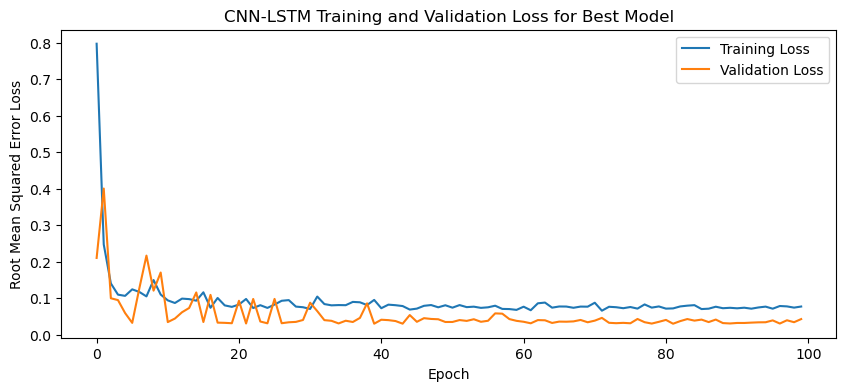

1/1 - 1s - loss: 0.0834 - 914ms/epoch - 914ms/step
Test Loss: 0.08338117599487305
Fold 2:
Epoch 1/100
19/19 [==============================] - 5s 97ms/step - loss: 0.3813 - val_loss: 0.1575
Epoch 2/100
19/19 [==============================] - 1s 44ms/step - loss: 0.1293 - val_loss: 0.0569
Epoch 3/100
19/19 [==============================] - 1s 45ms/step - loss: 0.1356 - val_loss: 0.2607
Epoch 4/100
19/19 [==============================] - 1s 46ms/step - loss: 0.1787 - val_loss: 0.1518
Epoch 5/100
19/19 [==============================] - 1s 45ms/step - loss: 0.1788 - val_loss: 0.0561
Epoch 6/100
19/19 [==============================] - 1s 45ms/step - loss: 0.0918 - val_loss: 0.1191
Epoch 7/100
19/19 [==============================] - 1s 45ms/step - loss: 0.1243 - val_loss: 0.1868
Epoch 8/100
19/19 [==============================] - 1s 43ms/step - loss: 0.0992 - val_loss: 0.1049
Epoch 9/100
19/19 [==============================] - 1s 42ms/step - loss: 0.0883 - val_loss: 0.0760
Epoch 10/1

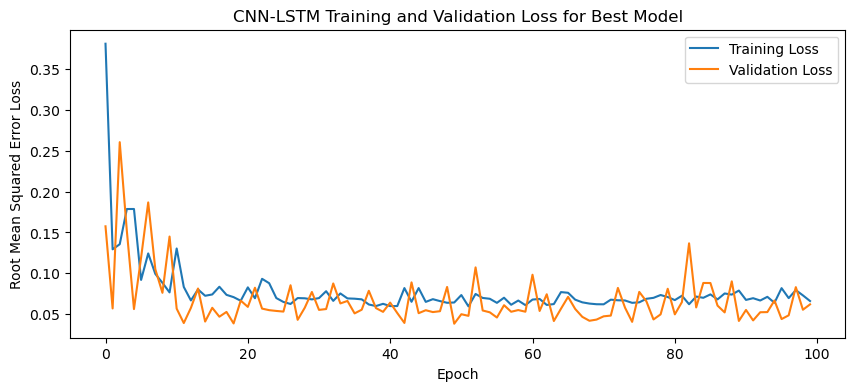

1/1 - 1s - loss: 0.1264 - 1s/epoch - 1s/step
Test Loss: 0.12643758952617645
Fold 3:
Epoch 1/100
19/19 [==============================] - 6s 99ms/step - loss: 0.7063 - val_loss: 0.0748
Epoch 2/100
19/19 [==============================] - 1s 42ms/step - loss: 0.1785 - val_loss: 0.0876
Epoch 3/100
19/19 [==============================] - 1s 42ms/step - loss: 0.0816 - val_loss: 0.0879
Epoch 4/100
19/19 [==============================] - 1s 42ms/step - loss: 0.1063 - val_loss: 0.1688
Epoch 5/100
19/19 [==============================] - 1s 42ms/step - loss: 0.1136 - val_loss: 0.2716
Epoch 6/100
19/19 [==============================] - 1s 43ms/step - loss: 0.1194 - val_loss: 0.0860
Epoch 7/100
19/19 [==============================] - 1s 43ms/step - loss: 0.0974 - val_loss: 0.0821
Epoch 8/100
19/19 [==============================] - 1s 43ms/step - loss: 0.0719 - val_loss: 0.1420
Epoch 9/100
19/19 [==============================] - 1s 42ms/step - loss: 0.1641 - val_loss: 0.0898
Epoch 10/100
19/

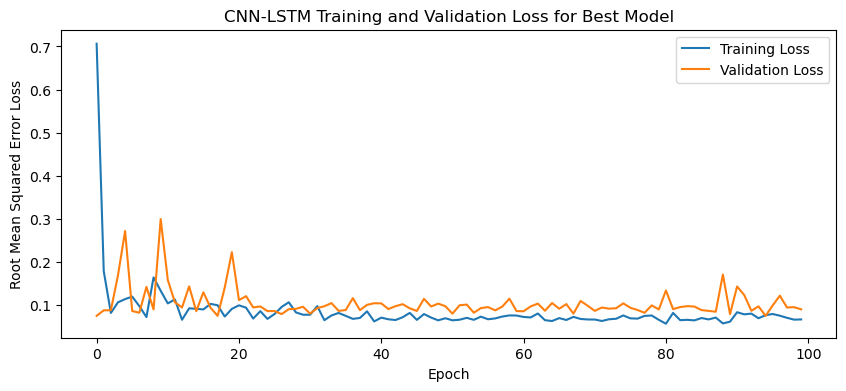

1/1 - 1s - loss: 0.0982 - 872ms/epoch - 872ms/step
Test Loss: 0.0981597900390625
Fold 4:
Epoch 1/100
20/20 [==============================] - 5s 92ms/step - loss: 0.4513 - val_loss: 0.3546
Epoch 2/100
20/20 [==============================] - 1s 41ms/step - loss: 0.2102 - val_loss: 0.2741
Epoch 3/100
20/20 [==============================] - 1s 41ms/step - loss: 0.1816 - val_loss: 0.0966
Epoch 4/100
20/20 [==============================] - 1s 42ms/step - loss: 0.1359 - val_loss: 0.1719
Epoch 5/100
20/20 [==============================] - 1s 42ms/step - loss: 0.1351 - val_loss: 0.0394
Epoch 6/100
20/20 [==============================] - 1s 43ms/step - loss: 0.1699 - val_loss: 0.3110
Epoch 7/100
20/20 [==============================] - 1s 43ms/step - loss: 0.2074 - val_loss: 0.1299
Epoch 8/100
20/20 [==============================] - 1s 44ms/step - loss: 0.1331 - val_loss: 0.1438
Epoch 9/100
20/20 [==============================] - 1s 45ms/step - loss: 0.1207 - val_loss: 0.0244
Epoch 10/10

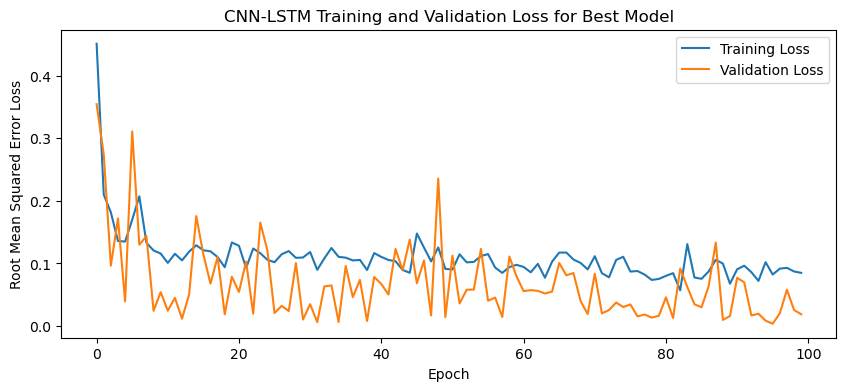

1/1 - 1s - loss: 0.1420 - 892ms/epoch - 892ms/step
Test Loss: 0.14197121560573578
Fold 5:
Epoch 1/100
19/19 [==============================] - 6s 103ms/step - loss: 0.4514 - val_loss: 0.2353
Epoch 2/100
19/19 [==============================] - 1s 44ms/step - loss: 0.1360 - val_loss: 0.2947
Epoch 3/100
19/19 [==============================] - 1s 43ms/step - loss: 0.2311 - val_loss: 0.0894
Epoch 4/100
19/19 [==============================] - 1s 42ms/step - loss: 0.1284 - val_loss: 0.2170
Epoch 5/100
19/19 [==============================] - 1s 42ms/step - loss: 0.1247 - val_loss: 0.0501
Epoch 6/100
19/19 [==============================] - 1s 42ms/step - loss: 0.1033 - val_loss: 0.0574
Epoch 7/100
19/19 [==============================] - 1s 43ms/step - loss: 0.1211 - val_loss: 0.0566
Epoch 8/100
19/19 [==============================] - 1s 43ms/step - loss: 0.1043 - val_loss: 0.0789
Epoch 9/100
19/19 [==============================] - 1s 42ms/step - loss: 0.0917 - val_loss: 0.1148
Epoch 10/

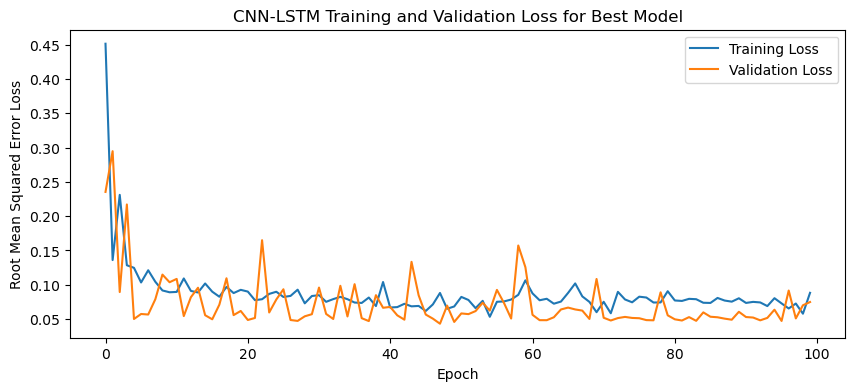

1/1 - 1s - loss: 0.1377 - 916ms/epoch - 916ms/step
Test Loss: 0.13767848908901215


In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit a CNN-LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    filters = trial.suggest_categorical('filters', [256, 512, 1024]) # Used for CNN-LSTM model
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM Only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "CNN-LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "CNN-LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

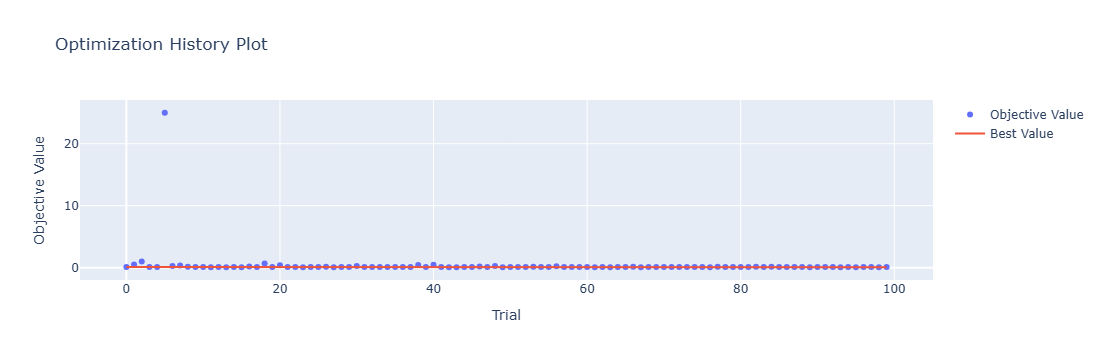

In [4]:
optuna.visualization.plot_optimization_history(study)

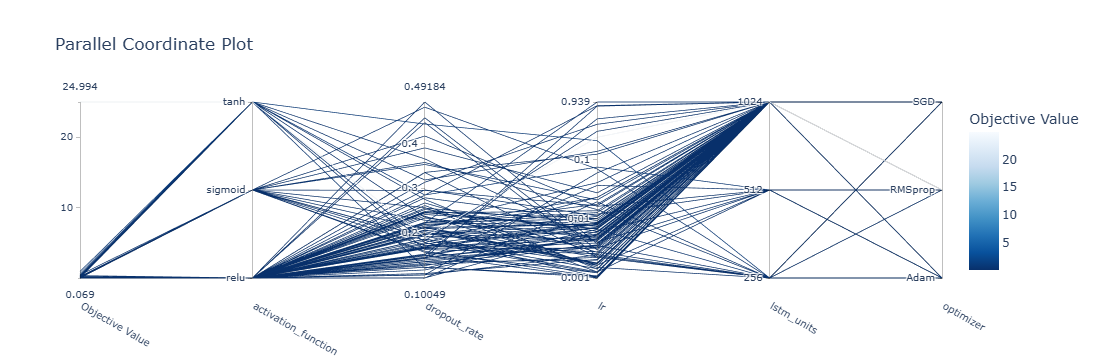

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

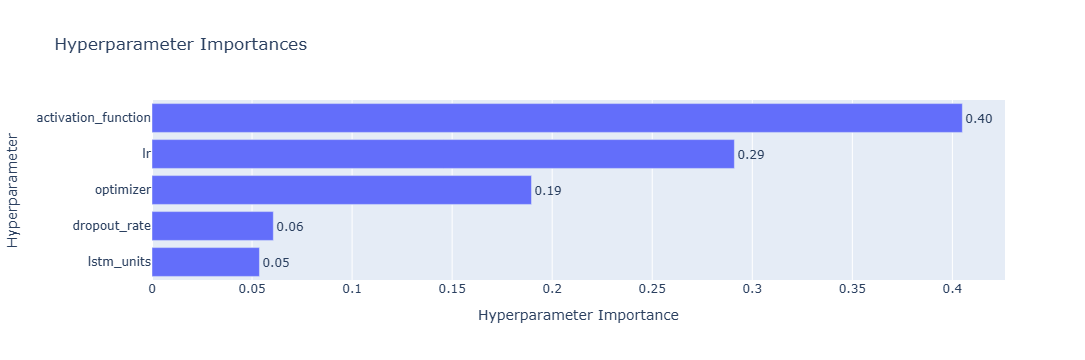

In [6]:
optuna.visualization.plot_param_importances(study)

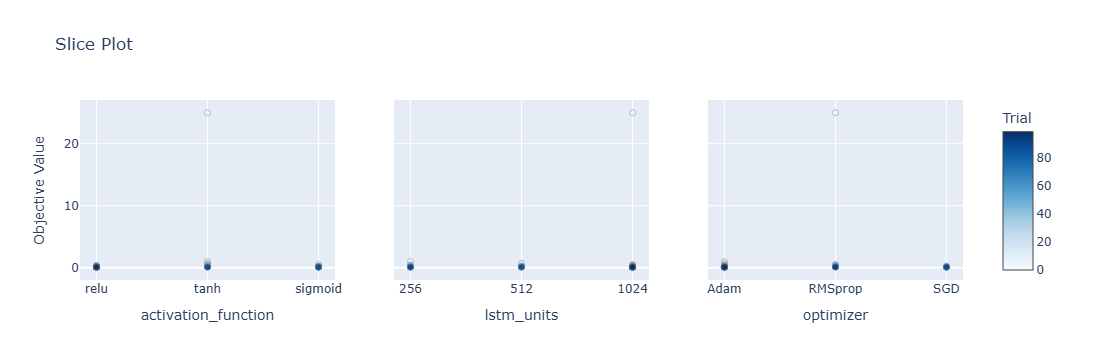

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

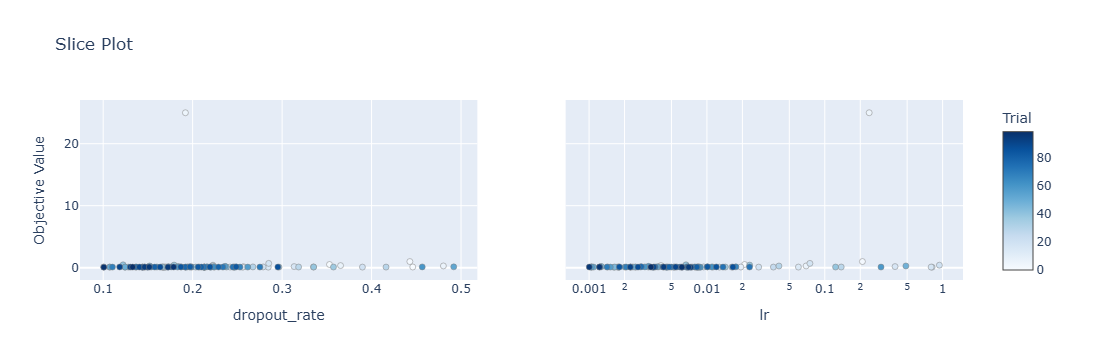

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate'])

[[12.82 12.33 12.14 11.9  12.75 12.05 11.96 11.88 11.66 11.6  11.21 11.85
  11.29 12.12 12.23 11.95 11.91 12.96 13.05 13.43 12.59 12.54 12.66 12.47
  12.18 12.49 13.25]
 [10.07  9.17  8.73  9.1   9.64  9.62  9.38  9.31  8.9   8.65  8.67  9.09
   8.97  9.33  9.58  9.53  9.17 10.25  9.66 10.33 10.45 10.26 10.47 10.03
   9.51  9.7  10.33]]
Epoch 1/100
19/19 [==============================] - 22s 371ms/step - loss: 0.5965 - accuracy: 0.0000e+00 - mae: 0.5965 - rmse: 0.5965 - mape: 138.1539 - pearson: nan - val_loss: 0.1935 - val_accuracy: 0.0000e+00 - val_mae: 0.1935 - val_rmse: 0.1935 - val_mape: 40.9174 - val_pearson: nan
Epoch 2/100
19/19 [==============================] - 2s 106ms/step - loss: 0.1162 - accuracy: 0.0000e+00 - mae: 0.1162 - rmse: 0.1162 - mape: 26.2293 - pearson: nan - val_loss: 0.0406 - val_accuracy: 0.0000e+00 - val_mae: 0.0406 - val_rmse: 0.0406 - val_mape: 9.2253 - val_pearson: nan
Epoch 3/100
19/19 [==============================] - 1s 78ms/step - loss: 0.1033 - acc

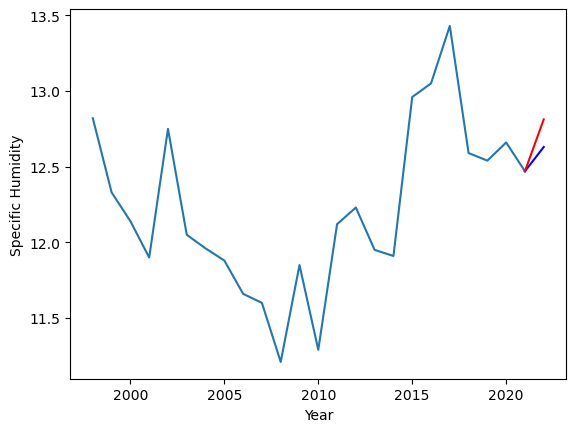

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
9.63		10.06		0.43


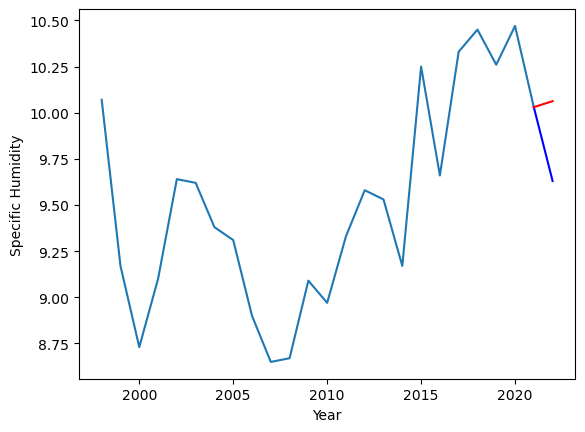

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   12.63  12.812538
1                1    9.63  10.062541


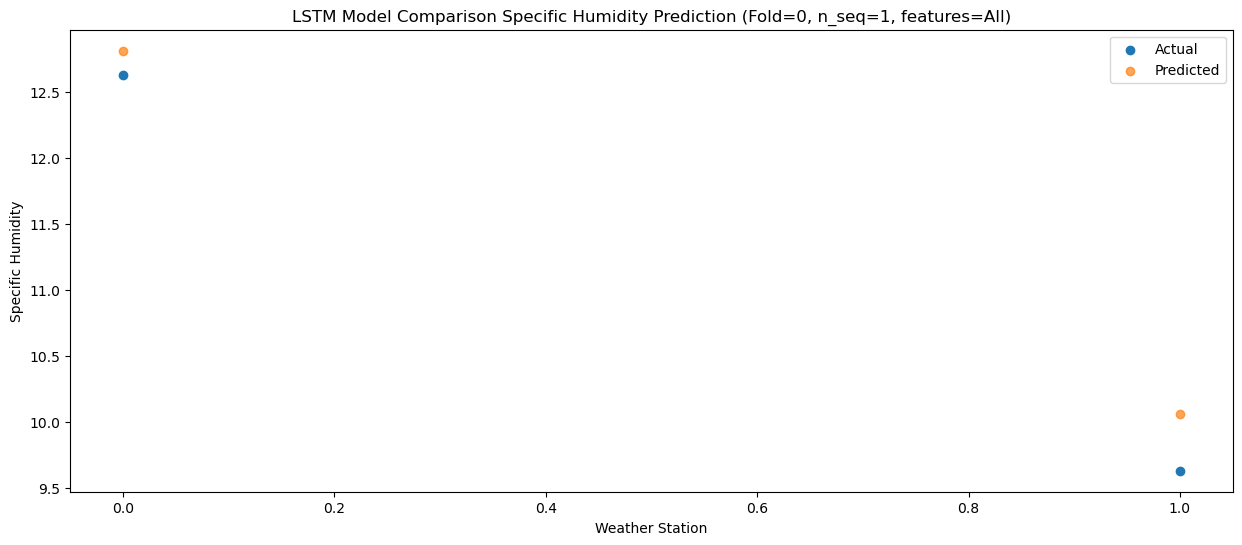

f, t:
[[12.63  9.63]]
[[12.81253814 10.06254135]]
Year at t+1:
t+1 SKRMSE: 0.331973
t+1 KRMSE: 0.331973
t+1 MAE: 0.307540
t+1 SKMAPE: 0.029684
t+1 R2_SCORE: 0.951020
t+1 KMAPE: 0.029684
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 11.130000
Metrics for this Fold:
SKRMSE: 0.331973
KRMSE: 0.331973
MAE: 0.307540
SKMAPE: 0.029684
R2_SCORE: 0.951020
KMAPE: 0.029684
PEARSON: 1.000000
AVERAGE ACTUAL: 11.130000
Model: "sequential_510"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1020 (LSTM)            (1, 1, 1024)              5279744   
                                                                 
 dropout_1020 (Dropout)      (1, 1, 1024)              0         
                                                                 
 lstm_1021 (LSTM)            (1, 1024)                 8392704   
                                                                 
 dropout_1021 (Dropout)      (1, 1024)      

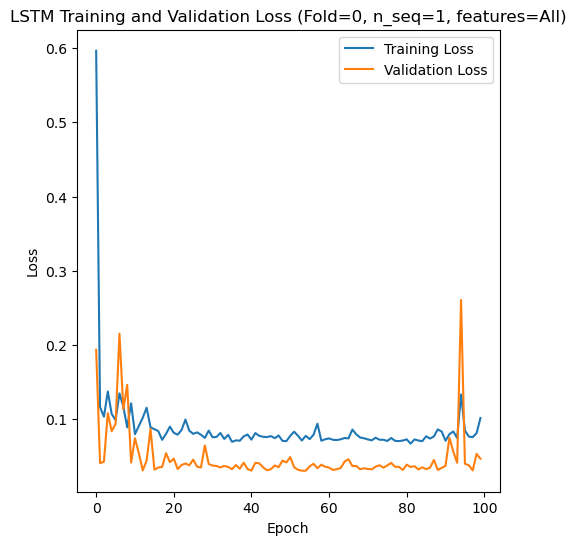

[[11.47 10.69 10.49 10.89 11.27 10.87 11.1  11.03 10.18 10.34 10.24 10.68
  10.6  10.94 10.76 10.47 10.42 11.26 10.81 11.26 11.81 11.14 11.5  10.83
  10.88 10.74 11.48]
 [ 7.63  7.36  7.16  7.53  7.72  7.87  8.49  7.73  6.89  8.03  6.62  6.93
   7.69  5.78  7.04  6.89  7.21  8.34  8.32  7.95  7.79  7.82  7.08  7.52
   6.95  7.1   7.65]]
Epoch 1/100
19/19 [==============================] - 22s 361ms/step - loss: 0.3874 - accuracy: 0.0000e+00 - mae: 0.3874 - rmse: 0.3874 - mape: 85.4667 - pearson: nan - val_loss: 0.0623 - val_accuracy: 0.0000e+00 - val_mae: 0.0623 - val_rmse: 0.0623 - val_mape: 11.3904 - val_pearson: nan
Epoch 2/100
19/19 [==============================] - 2s 97ms/step - loss: 0.1311 - accuracy: 0.0000e+00 - mae: 0.1311 - rmse: 0.1311 - mape: 28.3873 - pearson: nan - val_loss: 0.1099 - val_accuracy: 0.0000e+00 - val_mae: 0.1099 - val_rmse: 0.1099 - val_mape: 20.7243 - val_pearson: nan
Epoch 3/100
19/19 [==============================] - 2s 93ms/step - loss: 0.0868 - accu

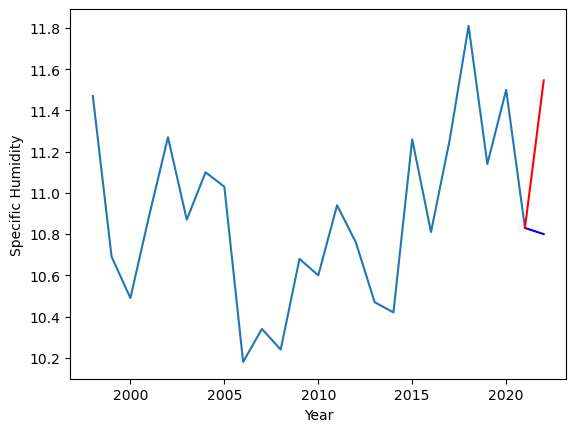

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.07		7.71		-0.36


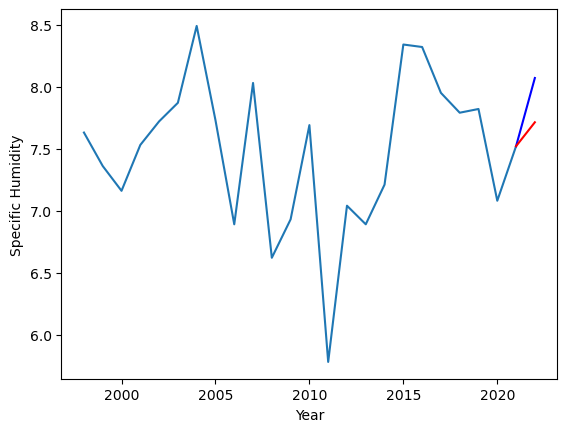

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   10.80  11.546077
1                1    8.07   7.712908


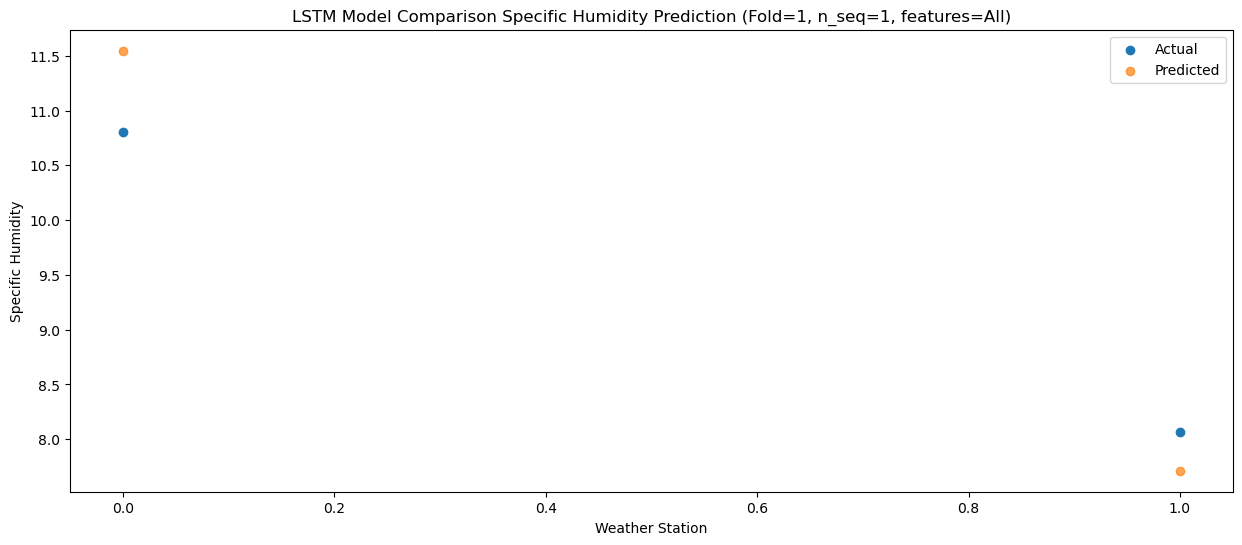

f, t:
[[10.8   8.07]]
[[11.54607739  7.712908  ]]
Year at t+1:
t+1 SKRMSE: 0.584870
t+1 KRMSE: 0.584870
t+1 MAE: 0.551585
t+1 SKMAPE: 0.056665
t+1 R2_SCORE: 0.816408
t+1 KMAPE: 0.056665
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 9.435000
Metrics for this Fold:
SKRMSE: 0.584870
KRMSE: 0.584870
MAE: 0.551585
SKMAPE: 0.056665
R2_SCORE: 0.816408
KMAPE: 0.056665
PEARSON: 1.000000
AVERAGE ACTUAL: 9.435000
Model: "sequential_511"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1022 (LSTM)            (1, 1, 1024)              5279744   
                                                                 
 dropout_1022 (Dropout)      (1, 1, 1024)              0         
                                                                 
 lstm_1023 (LSTM)            (1, 1024)                 8392704   
                                                                 
 dropout_1023 (Dropout)      (1, 1024)        

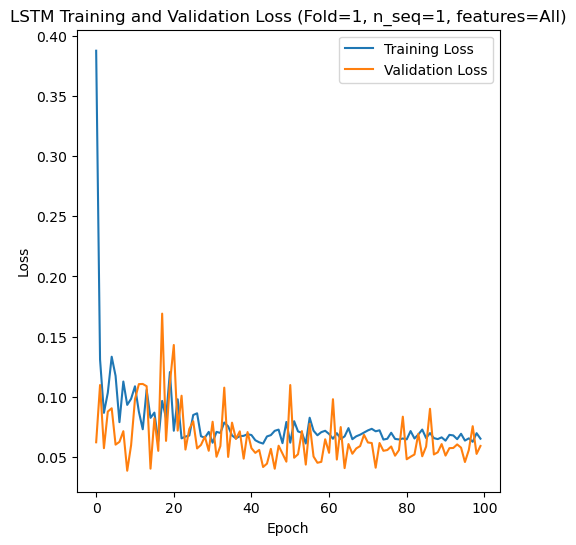

[[ 9.91  9.14  8.93  8.85  8.98  9.08  8.94  8.84  8.35  8.13  8.01  8.88
   8.79  8.86  9.22  8.7   8.51  9.48  9.05  9.73 10.13  9.86  9.33  8.92
   8.82  9.09  9.65]
 [ 8.49  7.33  7.71  7.76  7.77  7.75  7.45  7.41  7.43  7.25  7.05  7.35
   7.52  7.92  7.47  7.81  7.    7.75  8.3   8.25  8.35  7.7   7.52  7.59
   7.86  7.87  8.55]]
Epoch 1/100
19/19 [==============================] - 27s 310ms/step - loss: 0.4669 - accuracy: 0.0000e+00 - mae: 0.4669 - rmse: 0.4669 - mape: 106.5998 - pearson: nan - val_loss: 0.2184 - val_accuracy: 0.0000e+00 - val_mae: 0.2184 - val_rmse: 0.2184 - val_mape: 43.8280 - val_pearson: nan
Epoch 2/100
19/19 [==============================] - 1s 61ms/step - loss: 0.1741 - accuracy: 0.0000e+00 - mae: 0.1741 - rmse: 0.1741 - mape: 39.0530 - pearson: nan - val_loss: 0.3433 - val_accuracy: 0.0000e+00 - val_mae: 0.3433 - val_rmse: 0.3433 - val_mape: 62.0452 - val_pearson: nan
Epoch 3/100
19/19 [==============================] - 1s 63ms/step - loss: 0.1092 - acc

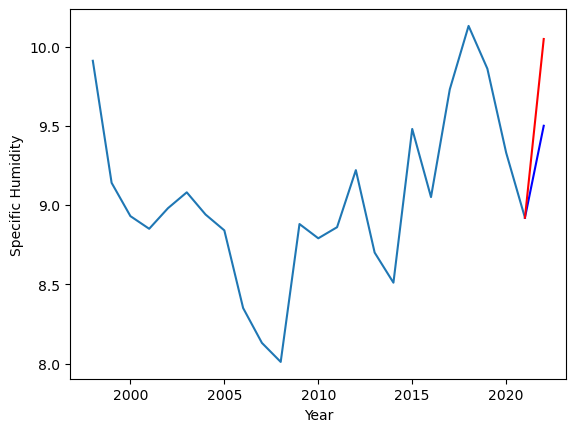

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.56		8.65		0.09


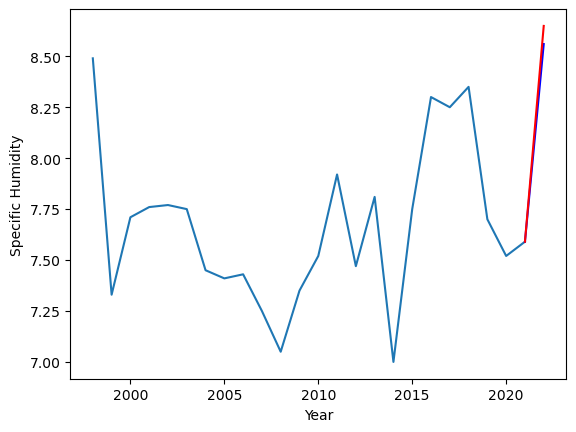

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0    9.50  10.047582
1                1    8.56   8.649084


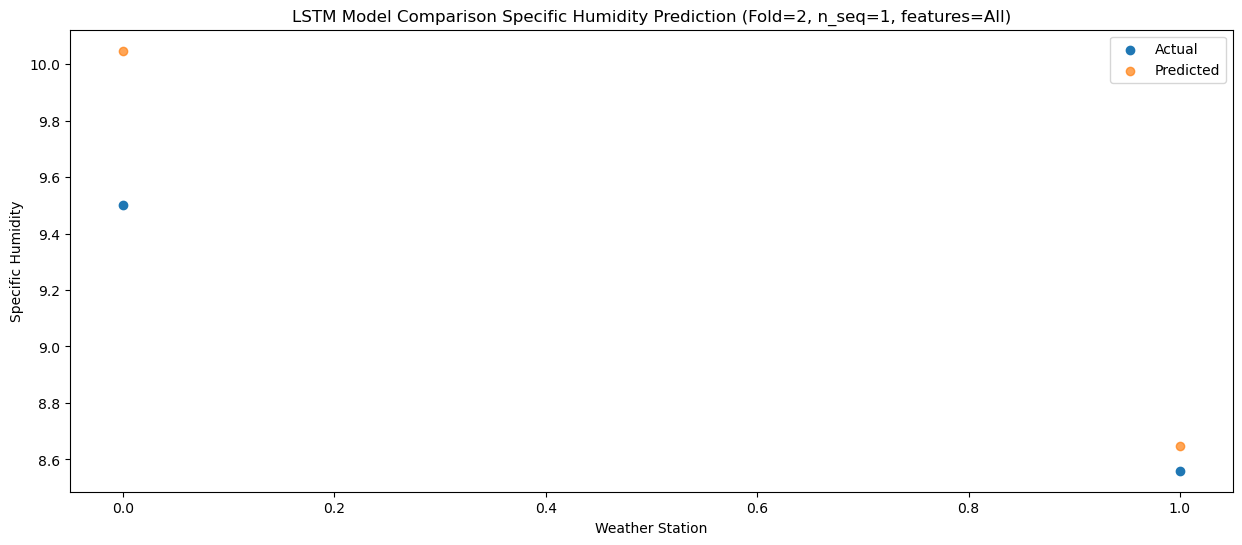

f, t:
[[9.5  8.56]]
[[10.04758211  8.64908372]]
Year at t+1:
t+1 SKRMSE: 0.392289
t+1 KRMSE: 0.392289
t+1 MAE: 0.318333
t+1 SKMAPE: 0.034024
t+1 R2_SCORE: 0.303345
t+1 KMAPE: 0.034024
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 9.030000
Metrics for this Fold:
SKRMSE: 0.392289
KRMSE: 0.392289
MAE: 0.318333
SKMAPE: 0.034024
R2_SCORE: 0.303345
KMAPE: 0.034024
PEARSON: 1.000000
AVERAGE ACTUAL: 9.030000
Model: "sequential_512"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1024 (LSTM)            (1, 1, 1024)              5279744   
                                                                 
 dropout_1024 (Dropout)      (1, 1, 1024)              0         
                                                                 
 lstm_1025 (LSTM)            (1, 1024)                 8392704   
                                                                 
 dropout_1025 (Dropout)      (1, 1024)          

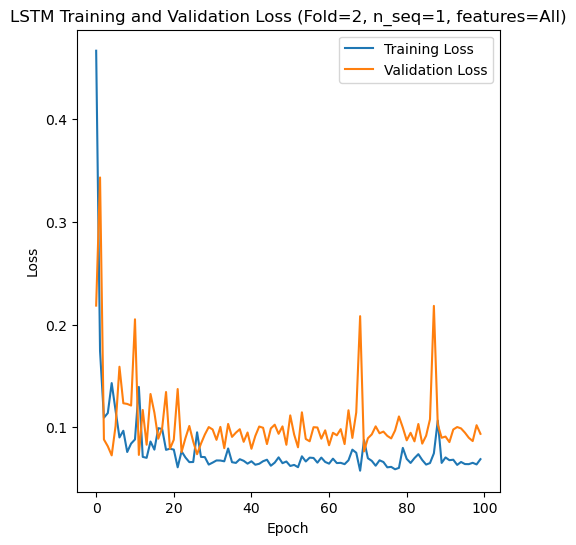

[[4.45 7.03 7.66 7.5  7.   7.5  6.8  7.19 6.85 6.32 6.46 6.61 7.06 6.53
  6.68 6.3  6.77 6.95 6.79 7.44 7.02 7.12 7.47 7.01 6.62 7.19 7.31]
 [8.33 7.39 7.85 8.23 8.15 7.91 8.01 7.7  7.52 7.54 7.12 7.57 7.71 8.23
  7.93 7.83 7.45 8.09 8.19 8.01 8.37 8.25 8.16 8.13 7.66 7.68 8.3 ]]
Epoch 1/100
20/20 [==============================] - 11s 209ms/step - loss: 0.6146 - accuracy: 0.0000e+00 - mae: 0.6146 - rmse: 0.6146 - mape: 113.2519 - pearson: nan - val_loss: 0.0067 - val_accuracy: 0.0000e+00 - val_mae: 0.0067 - val_rmse: 0.0067 - val_mape: 0.9637 - val_pearson: nan
Epoch 2/100
20/20 [==============================] - 1s 48ms/step - loss: 0.3221 - accuracy: 0.0000e+00 - mae: 0.3221 - rmse: 0.3221 - mape: 53.9263 - pearson: nan - val_loss: 0.3503 - val_accuracy: 0.0000e+00 - val_mae: 0.3503 - val_rmse: 0.3503 - val_mape: 50.3401 - val_pearson: nan
Epoch 3/100
20/20 [==============================] - 1s 49ms/step - loss: 0.1682 - accuracy: 0.0000e+00 - mae: 0.1682 - rmse: 0.1682 - mape: 25.7

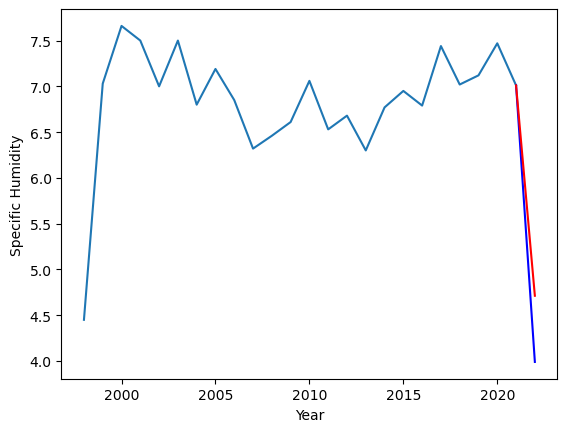

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.30		8.59		0.29


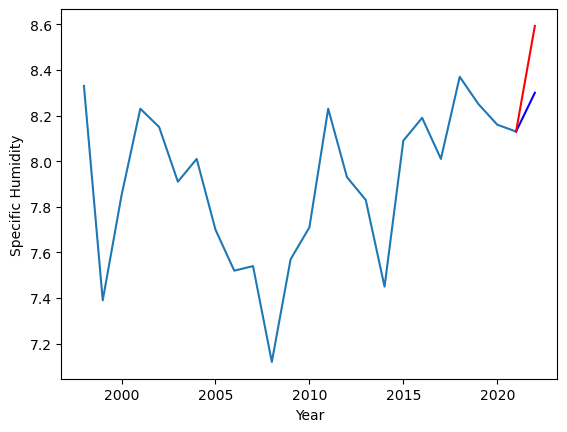

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0    3.99   4.712775
1                1    8.30   8.592985


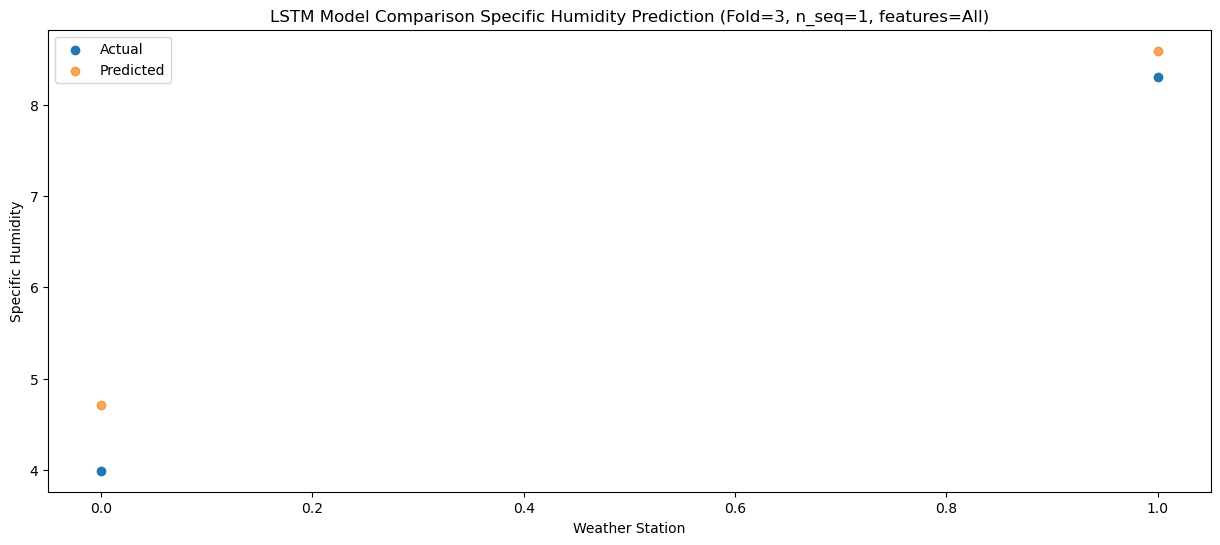

f, t:
[[3.99 8.3 ]]
[[4.71277465 8.59298478]]
Year at t+1:
t+1 SKRMSE: 0.551472
t+1 KRMSE: 0.551472
t+1 MAE: 0.507880
t+1 SKMAPE: 0.108223
t+1 R2_SCORE: 0.934513
t+1 KMAPE: 0.108223
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 6.145000
Metrics for this Fold:
SKRMSE: 0.551472
KRMSE: 0.551472
MAE: 0.507880
SKMAPE: 0.108223
R2_SCORE: 0.934513
KMAPE: 0.108223
PEARSON: 1.000000
AVERAGE ACTUAL: 6.145000
Model: "sequential_513"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1026 (LSTM)            (1, 1, 1024)              5279744   
                                                                 
 dropout_1026 (Dropout)      (1, 1, 1024)              0         
                                                                 
 lstm_1027 (LSTM)            (1, 1024)                 8392704   
                                                                 
 dropout_1027 (Dropout)      (1, 1024)            

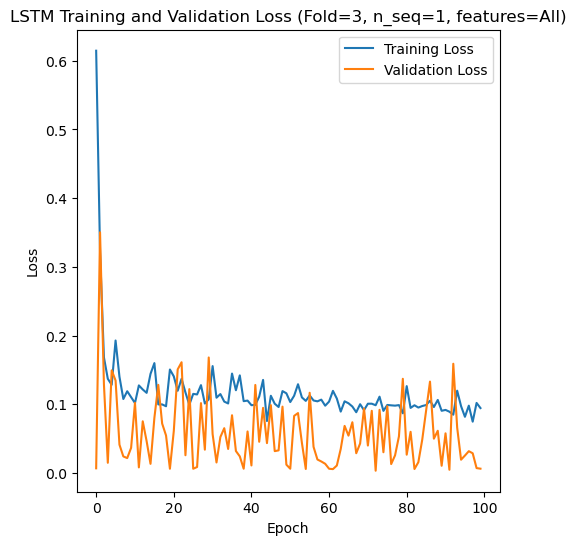

[[11.16  9.55  9.55 10.04  9.82  9.68 10.08  8.81  8.71 10.02  8.91  9.32
   9.71  8.86  9.35  8.98  8.99  9.85 10.25 10.41  9.69  9.69  9.59  9.94
   9.15  9.7  10.89]
 [ 8.33  7.32  7.52  7.52  7.95  7.22  7.21  7.13  7.15  7.14  7.22  7.24
   7.84  7.63  7.34  7.44  7.18  7.84  8.31  7.98  8.38  7.84  7.57  7.9
   7.3   7.53  8.43]]
Epoch 1/100
19/19 [==============================] - 6s 117ms/step - loss: 0.4860 - accuracy: 0.0000e+00 - mae: 0.4860 - rmse: 0.4860 - mape: 114.5055 - pearson: nan - val_loss: 0.0726 - val_accuracy: 0.0000e+00 - val_mae: 0.0726 - val_rmse: 0.0726 - val_mape: 16.2321 - val_pearson: nan
Epoch 2/100
19/19 [==============================] - 1s 43ms/step - loss: 0.1736 - accuracy: 0.0000e+00 - mae: 0.1736 - rmse: 0.1736 - mape: 40.7408 - pearson: nan - val_loss: 0.1160 - val_accuracy: 0.0000e+00 - val_mae: 0.1160 - val_rmse: 0.1160 - val_mape: 25.3013 - val_pearson: nan
Epoch 3/100
19/19 [==============================] - 1s 43ms/step - loss: 0.1498 - accur

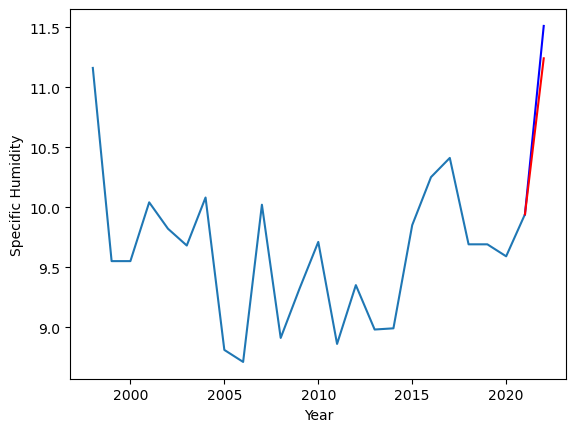

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.66		8.41		-0.25


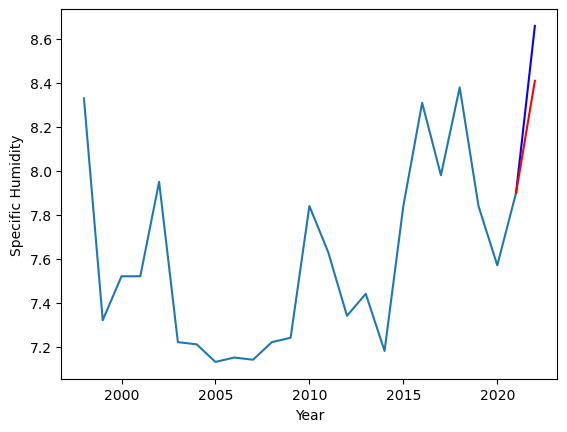

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   11.51  11.240042
1                1    8.66   8.410033


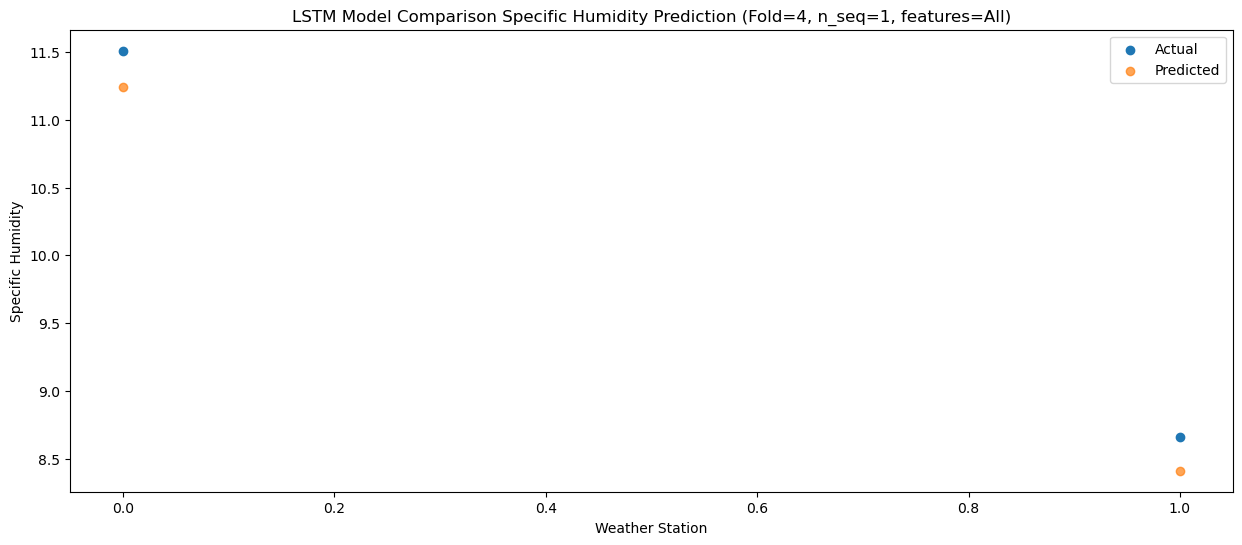

f, t:
[[11.51  8.66]]
[[11.24004232  8.41003303]]
Year at t+1:
t+1 SKRMSE: 0.260154
t+1 KRMSE: 0.260154
t+1 MAE: 0.259962
t+1 SKMAPE: 0.026159
t+1 R2_SCORE: 0.966670
t+1 KMAPE: 0.026159
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 10.085000
Metrics for this Fold:
SKRMSE: 0.260154
KRMSE: 0.260154
MAE: 0.259962
SKMAPE: 0.026159
R2_SCORE: 0.966670
KMAPE: 0.026159
PEARSON: 1.000000
AVERAGE ACTUAL: 10.085000
Model: "sequential_514"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1028 (LSTM)            (1, 1, 1024)              5279744   
                                                                 
 dropout_1028 (Dropout)      (1, 1, 1024)              0         
                                                                 
 lstm_1029 (LSTM)            (1, 1024)                 8392704   
                                                                 
 dropout_1029 (Dropout)      (1, 1024)      

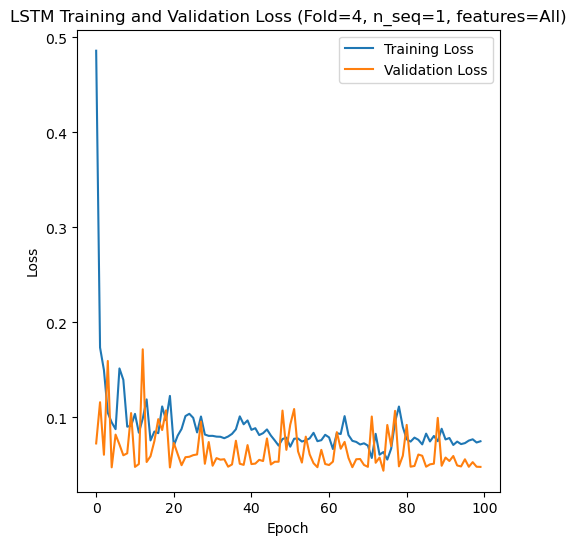

[[0.3319730324071688], [0.5848701465594097], [0.3922894819529051], [0.5514722441156649], [0.26015441000088024]]
[[array(0.33197303)], [array(0.58487015)], [array(0.39228948)], [array(0.55147224)], [array(0.26015441)]]
[[0.3075397417973731], [0.5515846985578539], [0.3183329162001609], [0.5078797143697735], [0.25996232420206056]]
[[0.02968438507397778], [0.056665279514421865], [0.0340235995199665], [0.10822294963533921], [0.02615936603610123]]
[[0.9510195136686174], [0.8164080621844247], [0.3033452347176151], [0.9345133508045355], [0.9666702039801016]]
[[array(0.02968439)], [array(0.05666528)], [array(0.0340236)], [array(0.10822295)], [array(0.02615937)]]
[[array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)]]
[12.63  9.63 10.8   8.07  9.5   8.56  3.99  8.3  11.51  8.66]
[12.81253814 10.06254135 11.54607739  7.712908   10.04758211  8.64908372
  4.71277465  8.59298478 11.24004232  8.41003303]
Accuracy Results:
RMSE for each fold:
[[0.3319730324071688], [0.5848701465594097], [0.3

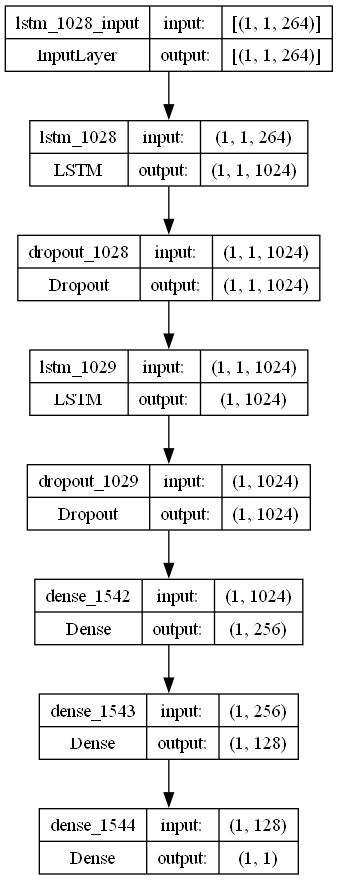

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def kmape (y_true, y_pred):
    return K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def kpearson (y_true, y_pred):
    mean_true = K.mean(y_true)
    mean_pred = K.mean(y_pred)
    return (K.square(K.mean((y_true - mean_true)*(y_pred - mean_pred))))/(K.mean(K.square(y_true - mean_true))*K.mean(K.square(y_pred - mean_pred)))

# fit the best CNN-LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    filters = 512
    lr = 0.003916316513762676
    optimizer = SGD(learning_rate = lr)
    activation_function = 'tanh'
    lstm_units = 1024
    dropout_rate = 0.2468857003842267

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# Make one forecast with a CNN-LSTM
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_cnnlstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# Evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_cnnlstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

   
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# Evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(actual, forecasts, n_lag, n_seq):

    t = np.array(actual).transpose()
    f = np.array(forecasts).transpose()

    print("f, t:")
    print(t)
    print(f)
    rmse_list = []
    mae_list = []
    skmape_list = []
    mape_list = []
    r2_list = []
    pearson_list = []
    actual_list = []

    for i in range(n_seq):
        act = [row for row in t[i]]
        predicted = [forecast for forecast in f[i]]
        rmse1 = sqrt(mean_squared_error(act, predicted))
        rmse2 = np.array(rmse(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        mae = mean_absolute_error(act, predicted)
        mse = mean_squared_error(act, predicted)
        skmape = mean_absolute_percentage_error(act, predicted)
        kmape1 = np.array(kmape(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        kpearson1 = np.array(kpearson(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        r2 = r2_score(act, predicted) 
        avg_actual = np.mean(act)
        print("Year at t+"+str(i+1)+":")
        print('t+%d SKRMSE: %f' % ((i+1), rmse1))
        print('t+%d KRMSE: %f' % ((i+1), rmse2))        
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d SKMAPE: %f' % ((i+1), skmape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))
        print('t+%d KMAPE: %f' % ((i+1), kmape1))
        print('t+%d PEARSON: %f' % ((i+1), kpearson1))
        print('t+%d AVERAGE ACTUAL: %f' % ((i+1), avg_actual))

    y_true = tf.convert_to_tensor(np.array(actual).flatten())
    y_pred = tf.convert_to_tensor(np.array(forecasts).flatten())

    rmse1 = sqrt(mean_squared_error(np.array(y_true), np.array(y_pred)))
    rmse2 = np.array(rmse(y_true, y_pred))
    mae = mean_absolute_error(np.array(y_true), np.array(y_pred))
    mse = mean_squared_error(np.array(y_true), np.array(y_pred))
    skmape = mean_absolute_percentage_error(np.array(y_true), np.array(y_pred))
    kmape1 = np.array(kmape(y_true, y_pred))
    kpearson1 = np.array(kpearson(y_true, y_pred))
    r2 = r2_score(np.array(y_true), np.array(y_pred)) 
    avg_actual = np.mean(np.array(y_true))
    rmse1_list.append(rmse1)
    rmse2_list.append(rmse2)
    mae_list.append(mae)
    skmape_list.append(skmape)
    pearson_list.append(kpearson1)
    mape_list.append(kmape1)
    r2_list.append(r2)
    actual_list.append(avg_actual)
    print("Metrics for this Fold:")
    print('SKRMSE: %f' % (rmse1))
    print('KRMSE: %f' % (rmse2))        
    print('MAE: %f' % (mae))
    print('SKMAPE: %f' % (skmape))
    print('R2_SCORE: %f' % (r2))
    print('KMAPE: %f' % (kmape1))
    print('PEARSON: %f' % (kpearson1))
    print('AVERAGE ACTUAL: %f' % (avg_actual))

    return rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list
     
# Plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, actual, n_test, n_seq, n_lag):
    # Plot the actual data in blue
    plt.plot(series[:n_lag+2].index, series[:n_lag+2].values)
    off_s = n_lag + 1
    off_e = off_s + len(actual) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + actual
    plt.plot(xaxis, yaxis, color='blue')
    # Plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Year")
    plt.ylabel("Specific Humidity")
    # show the plot
    plt.show()

n_batch = 1
n_test = 2
nb_epoch = 100
    
rmse1_avg_list = []
rmse2_avg_list = []
mae_avg_list = []
skmape_avg_list = []
r2_score_avg_list = []
mape_avg_list = []
pearson_avg_list = []
actual_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]
    
    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:2, :]
    dataset = dataset_df.values

    print(dataset)

    series = pd.Series(dataset[:, 0]) # Using first column (specific_humidity)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test, n_seq)

    # Print out plots of actual and predicted values for weather stations
    ws = [1,2]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    print(results_df)
    
    print("Actual and Forecasts:")
    print(actual)
    print(forecasts)
    
    for j in range(2):
        print("Weather Station "+str(j+1)+":")
        print("Actual S.H.\tPredicted S.H.\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:2, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (specific_humidity)
        forecasts_ws = forecasts[j]
        actual_ws = actual[j]

        # Set index starting from 1998
        series_ws.index = range(1998, 1998 + len(series_ws))        
        
        plot_forecasts(series_ws, forecasts_ws, actual_ws, n_test, n_seq, n_lag)

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(2):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)

        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='CNN-LSTM Model Comparison Specific Humidity Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=All)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Specific Humidity')
        plt.legend()
        plt.show()
    
    rmse1_list = [] # list stores sklearn's root mean squared errors for each future time prediction
    rmse2_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores mean absolute errors for each future time prediction
    skmape_list = [] # list stores sklearn's mean squared percentage errors for each future time prediction
    r2_list = [] # list stores sklearn's r2 pearson values for each future time prediction
    mape_list = [] # list stores mean squared percentage errors for each future time prediction
    pearson_list = [] # list stores r2 pearson values for each future time prediction
    actual_list = [] # list stores average actual values for each future time prediction

    # evaluate forecasts
    rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse1_avg_list.append(rmse1_list)
    rmse2_avg_list.append(rmse2_list)
    mae_avg_list.append(mae_list)
    skmape_avg_list.append(skmape_list)
    r2_score_avg_list.append(r2_list)
    mape_avg_list.append(mape_list)
    pearson_avg_list.append(pearson_list)
    actual_avg_list.append(actual_list)
    forecast_results.append(forecasts)
    actual_results.append(actual)
            
    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'CNN-LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=All)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse1_avg_list)
print(rmse2_avg_list)
print(mae_avg_list)
print(skmape_avg_list)
print(r2_score_avg_list)
print(mape_avg_list)
print(pearson_avg_list)
print(np.array(actual_results).flatten())
print(np.array(forecast_results).flatten())
a2 = np.array(actual_results).flatten()
f2 = np.array(forecast_results).flatten()
p1 = np.array(pearson(tf.convert_to_tensor(a2), tf.convert_to_tensor(f2)))
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse1_avg_list)
print("Average SKRMSE:"+str(np.mean(rmse1_avg_list)))
print("Average KRMSE:"+str(np.mean(rmse2_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average SKMAPE:"+str(np.mean(skmape_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average PEARSON:"+str(p1))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))
print("")
print("Average Specific Humidity:"+str(np.mean(actual_avg_list)))
print("RMSE % of Specific Humidity:"+str(np.mean(rmse2_avg_list)/np.mean(actual_avg_list)))

# Plot model architecture
filename = "cnnlstm_model_optimized_SH_S1.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)